In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import trange
from typing import List, Dict, Tuple, Optional, Any, Union, Sequence
from jaxtyping import Float, Int, UInt8
import cv2
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.auto import trange
from typing import List, Dict, Tuple, Optional, Any, Union, Sequence
from jaxtyping import Float, Int, UInt8
import torch
from torch.distributions import MultivariateNormal, Normal
import torch
from torch.distributions import MultivariateNormal, Normal

# Specify that we want our tensors on the GPU and in float32
device = torch.device('mps')
dtype = torch.float32

Number = Union[int, float]

# Helper function to convert between numpy arrays and tensors
to_t = lambda array: torch.tensor(array, device=device, dtype=dtype)
from_t = lambda tensor: tensor.to("cpu").detach().numpy().astype(np.float64)

In [2]:
video_path = 'data2/full.mp4'

cap = cv2.VideoCapture(video_path)

# Check if the video opened successfully
if not cap.isOpened():
    raise IOError(f"Cannot open video: {video_path}")

# Get total number of frames, width, and height
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

print(f'Full video:')
print(f'Frame count: {frame_count}')
print(f'Frame width: {frame_width}')
print(f'Frame height: {frame_height}')
print(f'FPS: {fps}')

Full video:
Frame count: 2330
Frame width: 640
Frame height: 480
FPS: 30.00030000300003


In [662]:
#Helper functions
def read_frames(video_path):
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        raise IOError(f"Cannot open video: {video_path}")

    # Get total number of frames, width, and height
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Preallocate numpy array for grayscale frames: T x H x W
    frames = np.empty((frame_count, frame_height, frame_width), dtype=np.uint8)

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        frames[frame_idx] = gray
        frame_idx += 1

    cap.release()

    # If fewer frames were read than expected (e.g., corrupted frames), truncate
    frames = frames[:frame_idx]
    return frames


def combine(Ta: Number,
            a: Optional[Tuple[torch.Tensor, ...]],
            Tb: Number,
            b: Optional[Tuple[torch.Tensor, ...]]
            ) -> Tuple[Number, Optional[Tuple[torch.Tensor, ...]]]:
    """
    Combines two (optional) tuples of statistics, 'a' and 'b', weighted by Ta and Tb.

    If 'a' is None, the function returns (Tb, b). If 'b' is None, it returns (Ta, a).
    Otherwise, it computes a new tuple where each element is a weighted average
    of the corresponding elements in 'a' and 'b'. The weights Ta and Tb are used
    for elements from 'a' and 'b' respectively, and (Ta + Tb) serves as the
    denominator for the average.

    Args:
        Ta: The numerical weight for the first tuple of statistics 'a'.
        a: An optional tuple of torch.Tensors or similar numerical sequences.
        Tb: The numerical weight for the second tuple of statistics 'b'.
        b: An optional tuple of torch.Tensors or similar numerical sequences.

    Returns:
        The return structure varies:
        - If `a` is None: Returns a 2-tuple `(Tb, b)`, where `Tb` is the
          weight and `b` is the original sequence of statistics.
        - If `b` is None: Returns a 2-tuple `(Ta, a)`, where `Ta` is the
          weight and `a` is the original sequence of statistics.
        - If both `a` and `b` are provided: Returns a single tuple containing
          the element-wise weighted average of statistics from `a` and `b`.
          Note that in this specific case, unlike the others, a combined weight
          is not returned alongside the resulting sequence.

    Note:
        The function asserts that at least one of 'a' or 'b' must be truthy
        (i.e., not None and not empty if it's a sequence that Python evaluates as False when empty).
        It is assumed that if both 'a' and 'b' are provided:
        - They are sequences (e.g., tuples of torch.Tensors) of the same length
          for a meaningful element-wise combination. `zip` will truncate to the
          length of the shorter sequence if lengths differ.
        - The sum of weights (Ta + Tb) is non-zero to avoid division by zero errors.
    """
    assert a or b
    if a is None:
        return Tb, b
    elif b is None:
        return Ta, a
    else:
        return tuple((Ta * ai + Tb * bi) / (Ta + Tb) for ai, bi in zip(a, b))
import cv2
import numpy as np
import cv2
import numpy as np

def create_keypoints_video(train_dataset, keypoints_type='original_keypoints', speed=40):
    """
    Overlays keypoints on the video and allows interactive navigation.

    Controls:
        - Enter: Pause / Resume playback
        - ← (Left arrow): Go back one frame (pauses if playing)
        - → (Right arrow): Go forward one frame (pauses if playing)
        - q: Quit

    Args:
        train_dataset: dataset containing keypoints
        keypoints_type: str, key to access keypoints in the dataset
    """
    video_path = f'data2/train_video/full_train.mp4'
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video at {video_path}")
        return

    keypoints = train_dataset[0][keypoints_type]
    head_coords = train_dataset[0]['head_coords']
    head_coords_expanded = head_coords.repeat(1, 9).numpy()
    keypoints = keypoints.numpy() + head_coords_expanded

    T, D = keypoints.shape
    num_kps = D // 2

    # Convert hex #d5d7d4 (RGB) to BGR for OpenCV
    blue_marker_bgr = (212, 215, 213)  # OpenCV uses BGR not RGB

    colors = [blue_marker_bgr] * num_kps
    radius = 4
    thickness = -1

    frame_idx = 0
    paused = False

    while cap.isOpened():
        if not paused:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if not ret or frame_idx >= T:
                break

            frame_kps = keypoints[frame_idx].reshape(-1, 2)
            for j, (x, y) in enumerate(frame_kps):
                if np.isnan(x) or np.isnan(y):
                    continue
                x_int, y_int = int(round(float(x))), int(round(float(y)))
                cv2.circle(frame, (x_int, y_int), radius, colors[j], thickness)

            cv2.imshow('Keypoint Overlay', frame)

        key = cv2.waitKey(speed) & 0xFF

        if key == ord('q'):
            break
        elif key == 13:  # Enter key toggles pause
            paused = not paused
        elif key == 81:  # Left arrow (←)
            paused = True
            frame_idx = max(0, frame_idx - 1)
        elif key == 83:  # Right arrow (→)
            paused = True
            frame_idx = min(T - 1, frame_idx + 1)
        elif not paused:
            frame_idx += 1

    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)


# Dataset Creation

In [663]:
import pandas as pd

def create_dataset(csv_path, video_path):

    """
    Create dataset from csv and video pathways with following tensors:
        centered_keypoints: T x 18 (w/o head_coords)
        original_keypoints: T x 18 (w/o head_coords)
        head_coords: T x 2
        frames: T x H x W
    """

    dataset = []
    data = {}

    df_csv = pd.read_csv(csv_path)
    head_coords = df_csv[['head_x_original', 'head_y_original']]
    df_csv.drop(columns=['head_x_original', 'head_y_original'], inplace=True)
    centered_keypoints = torch.tensor(df_csv.values, dtype=torch.float32)
    head_coords = torch.tensor(head_coords.values, dtype=torch.float32)

    head_coords_expanded = head_coords.repeat(1, 9)
    original_keypoints = centered_keypoints + head_coords_expanded

    data['centered_keypoints'] = centered_keypoints
    data['original_keypoints'] = original_keypoints
    data['head_coords'] = head_coords

    #normalize centered_keypoints
    means = torch.mean(centered_keypoints, axis=0)
    stds = torch.std(centered_keypoints, axis=0) + 1e-8
    centered_keypoints_normalized = (centered_keypoints - means) / stds
    data['centered_keypoints_normalized'] = centered_keypoints_normalized

    start_frame = 0
    frames = read_frames(video_path)
    num_frames = frames.shape[0]
    data['frames'] = torch.tensor(frames, dtype=torch.float32)
    dataset.append(data)
    start_frame += num_frames

    assert centered_keypoints.shape[0] == frames.shape[0]
    return dataset


In [664]:
#create original train test dataset
csv_train = 'data2/train_dataset/full_train_centered.csv'
csv_test = 'data2/test_dataset/full_test_centered.csv'
video_train = 'data2/train_video/full_train.mp4'
video_test = 'data2/test_video/full_test.mp4'

train_dataset = create_dataset(csv_train, video_train)
test_dataset = create_dataset(csv_test, video_test)

# Various Smoothing

In [665]:
from scipy.ndimage import median_filter, gaussian_filter1d

def smooth_keypoints(dataset):

    """
    Added following smoothing to dataset:
        gaussian_smoothed_keypoints_3: T x 18
        gaussian_smoothed_keypoints_6: T x 18
        median_smoothed_keypoints_3: T x 18
        median_smoothed_keypoints_5: T x 18
        gaussian_median_smoothed_keypoints_3: T x 18
        gaussian_median_smoothed_keypoints_6: T x 18

    Note all these smoothed keypoints are centered by head_coords as well
    """

    for data in dataset:
        original_keypoints = data['original_keypoints']
        T, D = original_keypoints.shape

        head_coords = data['head_coords']
        head_coords_expanded = head_coords.repeat(1, D//2).numpy()

        #gaussian smoothing
        smoothed_keypoints_3 = gaussian_filter1d(original_keypoints, 2, axis = 0)
        smoothed_keypoints_6 = gaussian_filter1d(original_keypoints, 6, axis = 0)
        gaussian_smoothed_keypoints_3 = smoothed_keypoints_3 - head_coords_expanded
        gaussian_smoothed_keypoints_6 = smoothed_keypoints_6 - head_coords_expanded
        data['gaussian_smoothed_keypoints_3'] = torch.tensor(gaussian_smoothed_keypoints_3, dtype=torch.float32)
        data['gaussian_smoothed_keypoints_6'] = torch.tensor(gaussian_smoothed_keypoints_6, dtype=torch.float32)

        #median smoothing
        median_smoothed_keypoints_3 = median_filter(original_keypoints, size = (2, 1))
        median_smoothed_keypoints_5 = median_filter(original_keypoints, size = (5, 1))
        median_smoothed_keypoints_3 = median_smoothed_keypoints_3 - head_coords_expanded
        median_smoothed_keypoints_5 = median_smoothed_keypoints_5 - head_coords_expanded
        data['median_smoothed_keypoints_3'] = torch.tensor(median_smoothed_keypoints_3, dtype=torch.float32)
        data['median_smoothed_keypoints_5'] = torch.tensor(median_smoothed_keypoints_5, dtype=torch.float32)

        #gaussian median mixture smoothing
        median_smoothed_keypoints = median_filter(original_keypoints, size = (3, 1))
        gaussian_smoothed_keypoints_3 = gaussian_filter1d(median_smoothed_keypoints, 3, axis = 0)
        gaussian_smoothed_keypoints_6 = gaussian_filter1d(median_smoothed_keypoints, 6, axis = 0)
        gaussian_smoothed_keypoints_3 = gaussian_smoothed_keypoints_3 - head_coords_expanded
        gaussian_smoothed_keypoints_6 = gaussian_smoothed_keypoints_6 - head_coords_expanded
        data['gaussian_median_smoothed_keypoints_3'] = torch.tensor(gaussian_smoothed_keypoints_3, dtype=torch.float32)
        data['gaussian_median_smoothed_keypoints_6'] = torch.tensor(gaussian_smoothed_keypoints_6, dtype=torch.float32)

    return None

smooth_keypoints(train_dataset)
smooth_keypoints(test_dataset)

# Manual Pose Constraint

In [666]:
#filtering conditions:
#nose, right_ear >= 50 pixels
#nose, left_ear >= 50 pixels
#mid_body, tail_base >= 80 pixels
#tail_base, tail_mid >= 100 pixels
#tail_mid, tail_tip >= 100 pixels

#CONSTANTS
pos = ['nose', 'left_ear', 'right_ear', 'mid_body', 'left_leg', 'right_leg', 'tail_base', 'tail_mid', 'tail_tip']
pos2index = {name: i for i, name in enumerate(pos)}

def distance(pos1, pos2, data):
    """
    Helper function to calculate the distance between two keypoint positions
    Args:
        pos1: str, the first keypoint position
        pos2: str, the second keypoint position
        dataset: list of dictionaries, the dataset
    Returns:
        dist: numpy array, the distance between the two keypoints
    """

    index1, index2 = pos2index[pos1], pos2index[pos2]
    original_keypoints = data['original_keypoints']
    _, D = original_keypoints.shape

    original_keypoints_xy = original_keypoints.reshape(-1, D//2, 2) #T, 9, 2
    dist = np.linalg.norm(original_keypoints_xy[:, index1] - original_keypoints_xy[:, index2], axis=1)

    return dist

def get_averaged_vel(pose_constrained_keypoints, i, pos, vel_time_lag):
    """
    Helper function to get the averaged velocity of a keypoint of previous vel_time_lag frames
    """
    index = pos2index[pos]
    pos_coords = pose_constrained_keypoints[:, 2*index:2*index+2] #T, 2
    avg_vel = torch.zeros(2)

    for j in range(vel_time_lag):
        prev_prev_cords = pos_coords[i - j - 2]
        prev_coords = pos_coords[i - j - 1]
        vel = prev_coords - prev_prev_cords
        avg_vel += vel

    avg_vel /= vel_time_lag

    return avg_vel
    
def pose_constrain_keypoints(dataset, vel_time_lag = 1):
    """
    Add the following pose constrained keypoints to dataset:
        pose_constrained_keypoints: T x 18
    """

    for data in dataset:
        original_keypoints = data['original_keypoints']
        T, D = original_keypoints.shape

        nose_left_ear_dist = distance('nose', 'left_ear', data)
        nose_right_ear_dist = distance('nose', 'right_ear', data)
        mid_body_tail_base_dist = distance('mid_body', 'tail_base', data)
        tail_base_tail_mid_dist = distance('tail_base', 'tail_mid', data)
        tail_mid_tail_tip_dist = distance('tail_mid', 'tail_tip', data)

        nose_left_ear_flag = (nose_left_ear_dist <= 60)
        nose_right_ear_flag = (nose_right_ear_dist <= 60)
        mid_body_tail_base_flag = (mid_body_tail_base_dist <= 100) 
        tail_base_tail_mid_flag  = (tail_base_tail_mid_dist <= 130) 
        tail_mid_tail_tip_flag = (tail_mid_tail_tip_dist <= 130)

        full_flag = nose_left_ear_flag & nose_right_ear_flag & mid_body_tail_base_flag & tail_base_tail_mid_flag & tail_mid_tail_tip_flag

        pose_constrained_keypoints = original_keypoints.clone()
        nose_index = pos2index['nose']
        left_ear_index = pos2index['left_ear']
        right_ear_index = pos2index['right_ear']
        mid_body_index = pos2index['mid_body']
        tail_base_index = pos2index['tail_base']
        tail_mid_index = pos2index['tail_mid']
        tail_tip_index = pos2index['tail_tip']

        for i in range(vel_time_lag, T):
            if not nose_left_ear_flag[i]:
                avg_nose_vel = get_averaged_vel(pose_constrained_keypoints, i, 'nose', vel_time_lag)
                avg_left_ear_vel = get_averaged_vel(pose_constrained_keypoints, i, 'left_ear', vel_time_lag)

                #update nose coords
                prev_nose_coords = pose_constrained_keypoints[i-1, 2*nose_index:2*nose_index+2]
                cur_nose_coords = prev_nose_coords + avg_nose_vel
                pose_constrained_keypoints[i, 2*nose_index:2*nose_index+2] = cur_nose_coords

                #update left ear coords
                prev_left_ear_coords = pose_constrained_keypoints[i-1, 2*left_ear_index:2*left_ear_index+2]
                cur_left_ear_coords = prev_left_ear_coords + avg_left_ear_vel
                pose_constrained_keypoints[i, 2*left_ear_index:2*left_ear_index+2] = cur_left_ear_coords
            
            if not nose_right_ear_flag[i]:
                avg_right_ear_vel = get_averaged_vel(pose_constrained_keypoints, i, 'right_ear', vel_time_lag)

                #update right ear coords
                prev_right_ear_coords = pose_constrained_keypoints[i-1, 2*right_ear_index:2*right_ear_index+2]
                cur_right_ear_coords = prev_right_ear_coords + avg_right_ear_vel
                pose_constrained_keypoints[i, 2*right_ear_index:2*right_ear_index+2] = cur_right_ear_coords
            
            if not mid_body_tail_base_flag[i]:
                avg_mid_body_vel = get_averaged_vel(pose_constrained_keypoints, i, 'mid_body', vel_time_lag)
                avg_tail_base_vel = get_averaged_vel(pose_constrained_keypoints, i, 'tail_base', vel_time_lag)

                #update mid body coords
                prev_mid_body_coords = pose_constrained_keypoints[i-1, 2*mid_body_index:2*mid_body_index+2]
                cur_mid_body_coords = prev_mid_body_coords + avg_mid_body_vel
                pose_constrained_keypoints[i, 2*mid_body_index:2*mid_body_index+2] = cur_mid_body_coords

                #update tail base coords
                prev_tail_base_coords = pose_constrained_keypoints[i-1, 2*tail_base_index:2*tail_base_index+2]
                cur_tail_base_coords = prev_tail_base_coords + avg_tail_base_vel
                pose_constrained_keypoints[i, 2*tail_base_index:2*tail_base_index+2] = cur_tail_base_coords
            
            if not tail_base_tail_mid_flag[i]:
                avg_tail_mid_vel = get_averaged_vel(pose_constrained_keypoints, i, 'tail_mid', vel_time_lag)

                #update tail mid coords
                prev_tail_mid_coords = pose_constrained_keypoints[i-1, 2*tail_mid_index:2*tail_mid_index+2]
                cur_tail_mid_coords = prev_tail_mid_coords + avg_tail_mid_vel
                pose_constrained_keypoints[i, 2*tail_mid_index:2*tail_mid_index+2] = cur_tail_mid_coords
            
            if not tail_mid_tail_tip_flag[i]:
                avg_tail_tip_vel = get_averaged_vel(pose_constrained_keypoints, i, 'tail_tip', vel_time_lag)

                #update tail tip coords
                prev_tail_tip_coords = pose_constrained_keypoints[i-1, 2*tail_tip_index:2*tail_tip_index+2]
                cur_tail_tip_coords = prev_tail_tip_coords + avg_tail_tip_vel
                pose_constrained_keypoints[i, 2*tail_tip_index:2*tail_tip_index+2] = cur_tail_tip_coords  

        #infer velocity vector from head keypoints
        head_coords = data['head_coords']

        head_coords = data['head_coords']
        head_coords_expanded = head_coords.repeat(1, D//2)
        pose_constrained_keypoints_centered = pose_constrained_keypoints - head_coords_expanded
        data['pose_constrained_keypoints'] = pose_constrained_keypoints_centered

        #gaussian smoothing
        gaussian_smoothed_pose_constrained_keypoints_3 = gaussian_filter1d(pose_constrained_keypoints_centered, 3, axis = 0)
        gaussian_smoothed_pose_constrained_keypoints_6 = gaussian_filter1d(pose_constrained_keypoints_centered, 6, axis = 0)
        data['gaussian_smoothed_pose_constrained_keypoints_3'] = torch.tensor(gaussian_smoothed_pose_constrained_keypoints_3, dtype=torch.float32)
        data['gaussian_smoothed_pose_constrained_keypoints_6'] = torch.tensor(gaussian_smoothed_pose_constrained_keypoints_6, dtype=torch.float32)
    
    print(f'Percentage of frames flagged: {full_flag.sum() / T}')

    return None

pose_constrain_keypoints(train_dataset)
pose_constrain_keypoints(test_dataset)

Percentage of frames flagged: 0.9427590154550658
Percentage of frames flagged: 0.9554030874785592


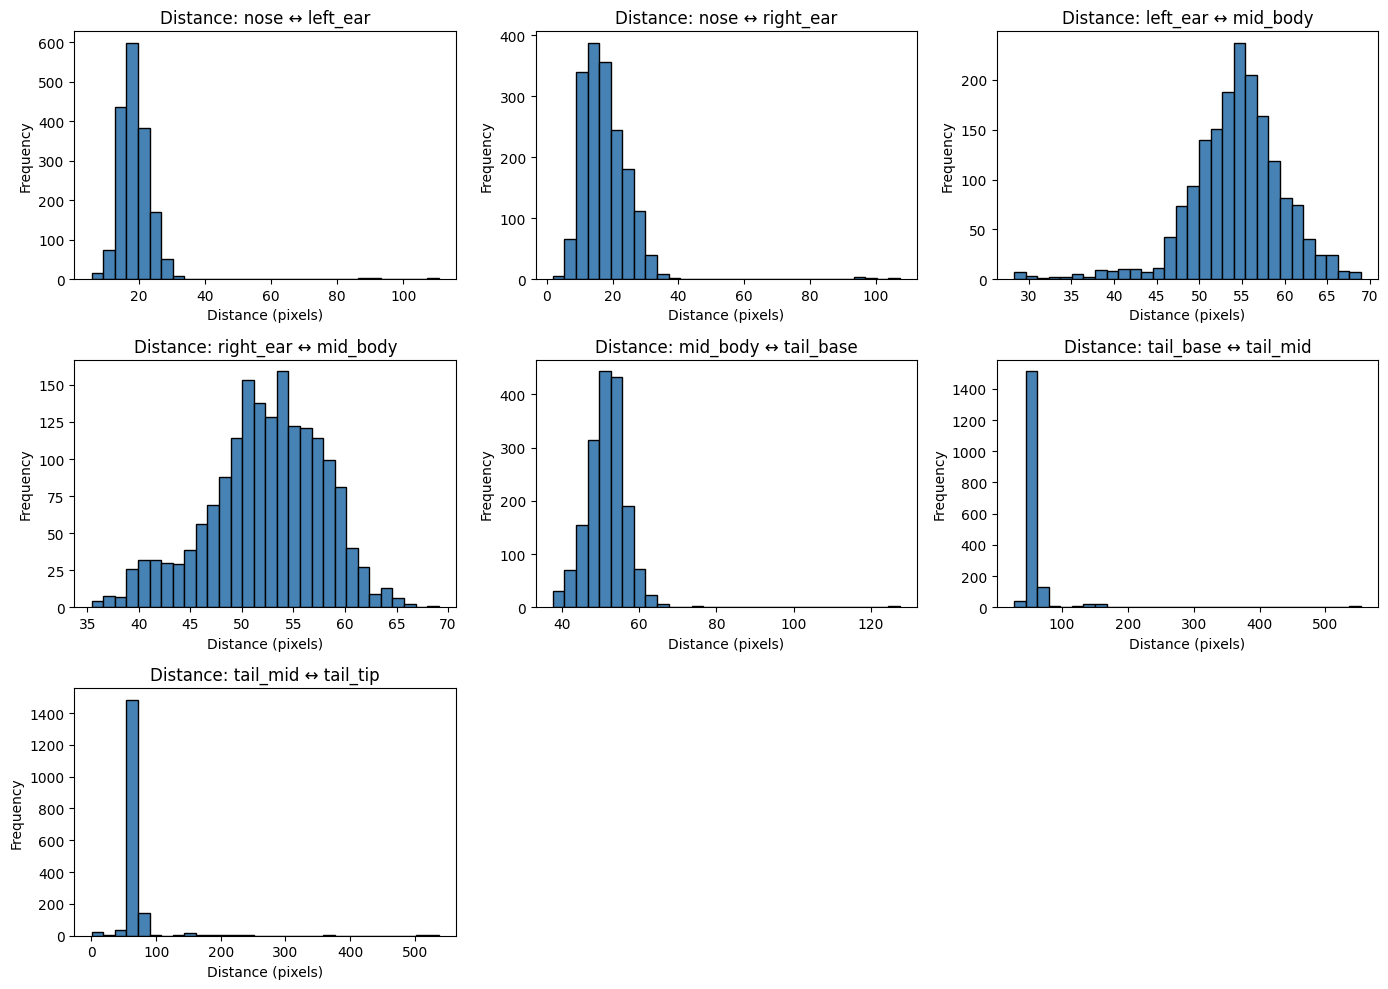

In [667]:
#EDA on distance histograms between skeletal keypoints
pos = ['nose', 'left_ear', 'right_ear', 'mid_body', 'left_leg', 'right_leg', 'tail_base', 'tail_mid', 'tail_tip']
pos_to_index = {name: i for i, name in enumerate(pos)}

pairs = [
    ('nose', 'left_ear'),
    ('nose', 'right_ear'),
    ('left_ear', 'mid_body'),
    ('right_ear', 'mid_body'),
    ('mid_body', 'tail_base'),
    ('tail_base', 'tail_mid'),
    ('tail_mid', 'tail_tip'),
]

original_keypoints = train_dataset[0]['original_keypoints']  # shape (T, 18)
T = original_keypoints.shape[0]
keypoints_xy = original_keypoints.reshape(T, len(pos), 2)

plt.figure(figsize=(14, 10))

for i, (a, b) in enumerate(pairs):
    idx_a = pos_to_index[a]
    idx_b = pos_to_index[b]

    dist = np.linalg.norm(keypoints_xy[:, idx_a] - keypoints_xy[:, idx_b], axis=1)
    plt.subplot(3, 3, i + 1)
    plt.hist(dist, bins=30, color='steelblue', edgecolor='black')
    plt.title(f'Distance: {a} ↔ {b}')
    plt.xlabel('Distance (pixels)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


#### Examine Manual Pose Constrained Keypoints

In [668]:
create_keypoints_video(train_dataset, keypoints_type='centered_keypoints', speed = 40)

2025-06-09 16:32:19.847 python[57791:12363096] +[IMKClient subclass]: chose IMKClient_Modern
2025-06-09 16:32:19.847 python[57791:12363096] +[IMKInputSession subclass]: chose IMKInputSession_Modern


# PCAs

In [9]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def create_keypoints_pca(dataset, num_PCA=5, dataset_name=''):
    """
    Add PCA from various keypoints to dataset:
        pca_centered_keypoints
        pca_gaussian_smoothed_keypoints
        pca_pose_constrained_keypoints
        pca_gaussian_smoothed_pose_constrained_keypoints
    Also prints explained variance ratios and plots them in a 2x2 grid.
    """
    variance_records = {}  # For plotting

    for data in dataset:
        # PCA on centered keypoints
        keypoints = data['centered_keypoints']  # T, D
        keypoints_mean_centered = keypoints - keypoints.mean(dim=0)
        pca = PCA(n_components=num_PCA)
        principal_components = pca.fit_transform(keypoints_mean_centered)
        data['pca_centered_keypoints'] = torch.tensor(principal_components, dtype=torch.float32)
        variance_records['Centered Keypoints'] = pca.explained_variance_ratio_
        print(f"{dataset_name} - Centered Keypoints: {pca.explained_variance_ratio_.sum():.2%} variance explained")

        # PCA on Gaussian-smoothed keypoints
        smoothed = data['gaussian_smoothed_keypoints_3']
        smoothed_mc = smoothed - smoothed.mean(dim=0)
        pca = PCA(n_components=num_PCA)
        principal_components = pca.fit_transform(smoothed_mc)
        data['pca_gaussian_smoothed_keypoints'] = torch.tensor(principal_components, dtype=torch.float32)
        variance_records['Gaussian-Smoothed Keypoints'] = pca.explained_variance_ratio_
        print(f"{dataset_name} - Gaussian-Smoothed Keypoints: {pca.explained_variance_ratio_.sum():.2%} variance explained")

        # PCA on pose-constrained keypoints
        constrained = data['pose_constrained_keypoints']
        constrained_mc = constrained - constrained.mean(dim=0)
        pca = PCA(n_components=num_PCA)
        principal_components = pca.fit_transform(constrained_mc)
        data['pca_pose_constrained_keypoints'] = torch.tensor(principal_components, dtype=torch.float32)
        variance_records['Pose-Constrained Keypoints'] = pca.explained_variance_ratio_
        print(f"{dataset_name} - Pose-Constrained Keypoints: {pca.explained_variance_ratio_.sum():.2%} variance explained")

        # PCA on Gaussian-smoothed pose-constrained keypoints
        smoothed_constrained = data['gaussian_smoothed_pose_constrained_keypoints_3']
        smoothed_constrained_mc = smoothed_constrained - smoothed_constrained.mean(dim=0)
        pca = PCA(n_components=num_PCA)
        principal_components = pca.fit_transform(smoothed_constrained_mc)
        data['pca_gaussian_smoothed_pose_constrained_keypoints'] = torch.tensor(principal_components, dtype=torch.float32)
        variance_records['Gaussian-Smoothed Pose-Constrained Keypoints'] = pca.explained_variance_ratio_
        print(f"{dataset_name} - Gaussian-Smoothed Pose-Constrained Keypoints: {pca.explained_variance_ratio_.sum():.2%} variance explained")

        break  # Only plot once per dataset

    # Plot explained variance ratios
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f'Explained Variance by Top {num_PCA} Principal Components ({dataset_name})', fontsize=14)
    for ax, (title, ratios) in zip(axs.flatten(), variance_records.items()):
        cumulative = ratios.cumsum() * 100  # Cumulative variance in %
        ax.plot(range(1, num_PCA + 1), cumulative, marker='o')
        ax.set_title(title)
        ax.set_xlabel('Principal Component')
        ax.set_ylabel('Cumulative % Variance Explained')
        ax.set_ylim(0, 100)
        ax.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


Train - Centered Keypoints: 96.39% variance explained
Train - Gaussian-Smoothed Keypoints: 97.03% variance explained
Train - Pose-Constrained Keypoints: 97.17% variance explained
Train - Gaussian-Smoothed Pose-Constrained Keypoints: 98.33% variance explained


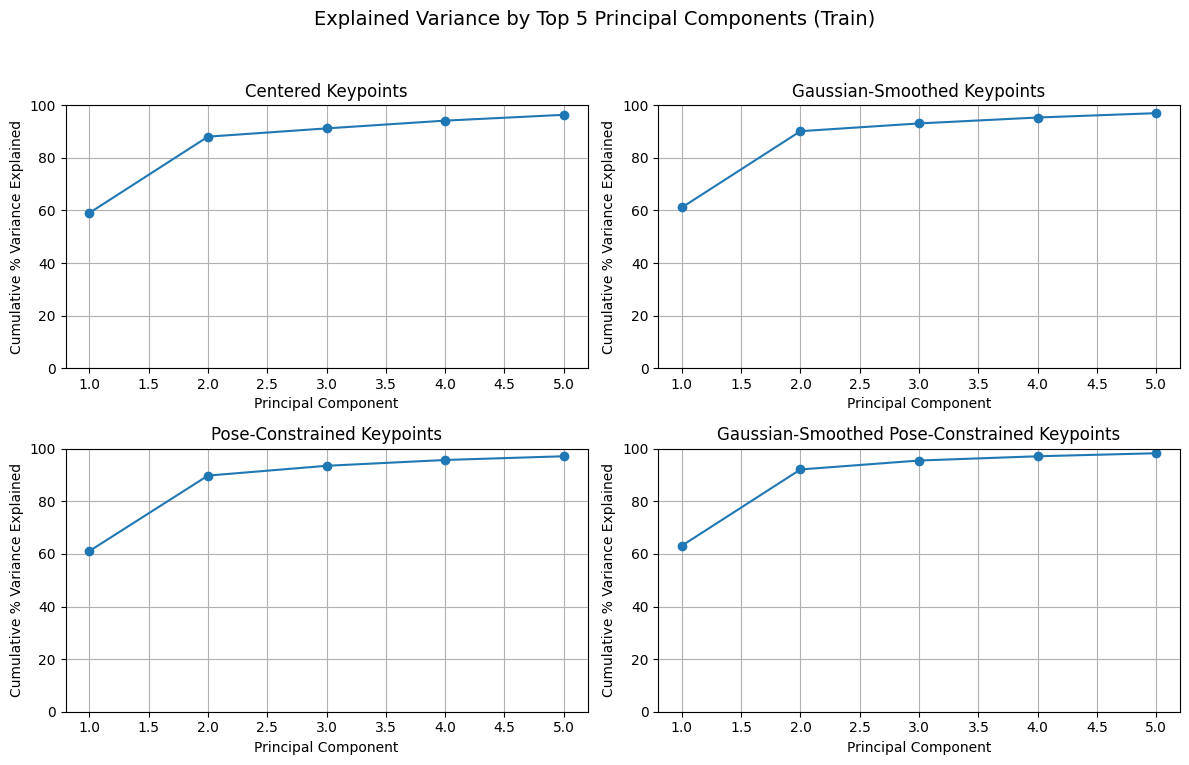

Test - Centered Keypoints: 98.44% variance explained
Test - Gaussian-Smoothed Keypoints: 99.17% variance explained
Test - Pose-Constrained Keypoints: 98.38% variance explained
Test - Gaussian-Smoothed Pose-Constrained Keypoints: 99.31% variance explained


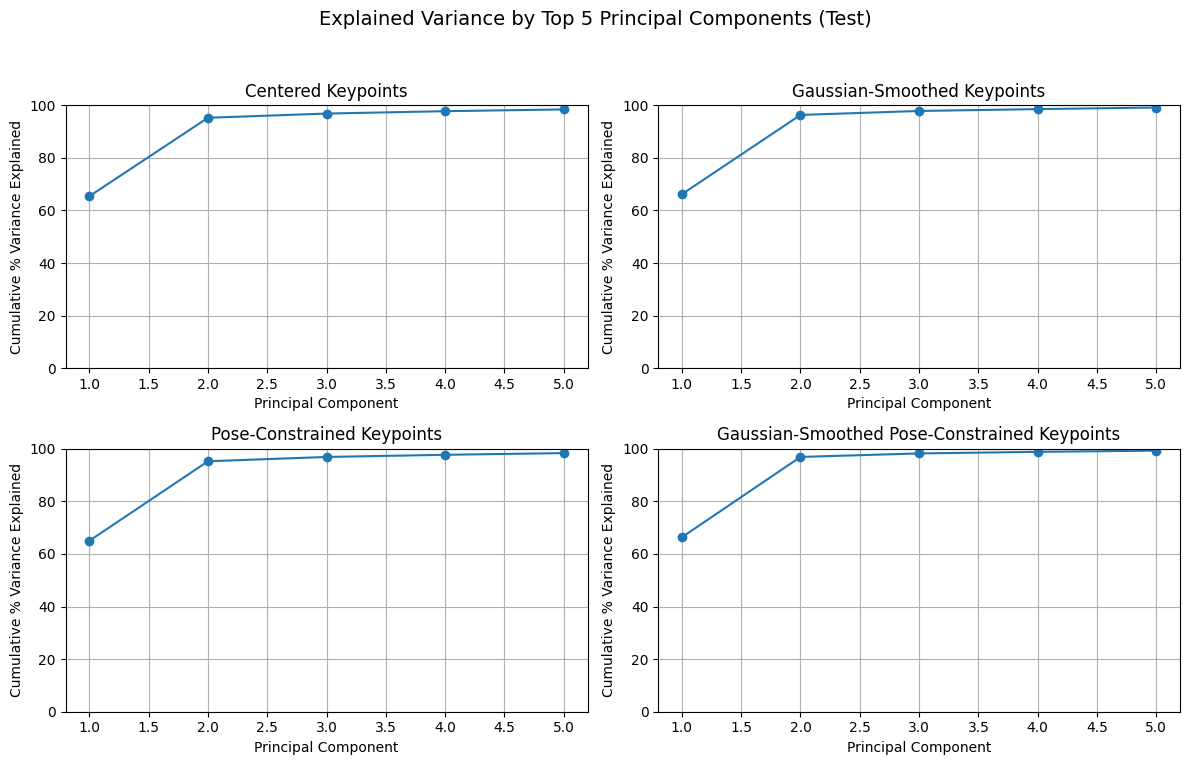

In [10]:
create_keypoints_pca(train_dataset, dataset_name='Train')
create_keypoints_pca(test_dataset, dataset_name='Test')

In [11]:
#pca_centered_keypoints
#pca_gaussian_smoothed_keypoints
#pca_pose_constrained_keypoints
#pca_gaussian_smoothed_pose_constrained_keypoints

def normalize_pca_fields(dataset, fields, mean_std_dict=None):
    """
    Normalize specified PCA fields in the dataset.

    Args:
        dataset: list of dicts, each with keys from `fields` containing T×D torch tensors.
        fields: list of strings, each representing a field to normalize.
        mean_std_dict: optional dict to use precomputed mean/std for each field.

    Returns:
        dataset: normalized in-place.
        mean_std_dict: dict mapping each field to (mean, std).
    """
    if mean_std_dict is None:
        mean_std_dict = {}

        # Compute mean and std for each field across all data
        for field in fields:
            stacked = torch.vstack([data[field] for data in dataset])
            mean = stacked.mean(dim=0)
            std = stacked.std(dim=0)
            mean_std_dict[field] = (mean, std)

    # Apply normalization using the stored mean and std
    for data in dataset:
        for field in fields:
            mean, std = mean_std_dict[field]
            data[field] = (data[field] - mean) / std

    return dataset, mean_std_dict

fields_to_normalize = [
    'pca_centered_keypoints',
    'pca_gaussian_smoothed_keypoints',
    'pca_pose_constrained_keypoints',
    'pca_gaussian_smoothed_pose_constrained_keypoints'
]

# Normalize train data and compute mean/std per field
train_dataset, norm_stats = normalize_pca_fields(train_dataset, fields_to_normalize)

# Normalize test data using the same stats
test_dataset, _ = normalize_pca_fields(test_dataset, fields_to_normalize, norm_stats)

### Helper Function for State Plot

In [488]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

#Log Likelihood Curves
def plot_log_likelihood_curves(train_lls, test_lls, title=None):
    plt.figure(figsize=(6, 4))

    plt.plot(train_lls, label="Train", color="#1f77b4", linewidth=2)
    plt.plot(test_lls, label="Test", color="#d62728", linewidth=2, linestyle="--")

    plt.title(title, fontsize=10)

    plt.xlabel("Iteration", fontsize=8)
    plt.ylabel("Average Marginal Log-Likelihood", fontsize=8)

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=9)
    plt.tight_layout()

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

#Plot state inference
def plot_stacked_pca_with_ghmm_states(X, ghmm_states, title="Stacked PCA Components with GHMM State Background"):
    """
    Plot top 5 PCA components stacked vertically with GHMM state background colors.

    Parameters:
    -----------
    X : np.ndarray or torch.Tensor
        PCA-reduced data of shape (T, 5)
    ghmm_states : array-like of shape (T,)
        Integer state labels (e.g., from GHMM; must be in range 0–4)
    title : str
        Title for the plot
    """
    # Convert to numpy if necessary
    if 'torch' in str(type(X)):
        X = X.detach().cpu().numpy()
    if 'torch' in str(type(ghmm_states)):
        ghmm_states = ghmm_states.detach().cpu().numpy()
    
    # Standardize the PCA components
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    T, D = X_std.shape
    assert D == 5, "Function assumes exactly 5 PCA components."

    time = np.arange(T)

    # Setup figure
    fig, ax = plt.subplots(figsize=(14, 8))

    # Soft contrasting colors that avoid deep blue
    state_colors = [
        "#fde0c5",  # soft peach
        "#c6f0c1",  # pale green
        "#fff2ae",  # soft yellow
        "#f8c6d2",  # light pink
        "#dad4ff"   # pale lavender
    ]
    num_states = 5

    # Plot GHMM state backgrounds as vertical bands
    for state in range(num_states):
        mask = ghmm_states == state
        start = None
        for t in range(T):
            if mask[t] and start is None:
                start = t
            elif not mask[t] and start is not None:
                ax.axvspan(start, t, color=state_colors[state], alpha=0.35)
                start = None
        if start is not None:
            ax.axvspan(start, T, color=state_colors[state], alpha=0.35)

    # Plot each PCA component stacked vertically with deep blue line
    spacing = 5
    for d in range(D):
        offset = d * spacing
        ax.plot(time, X_std[:, d] + offset, color='#0b3d91', linewidth=2.0)

    # Aesthetics
    ax.set_title(title)
    ax.set_xlabel("Frames")
    ax.set_yticks([i * spacing for i in range(D)])
    ax.set_yticklabels([f'PC {i+1}' for i in range(D)])
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)
    ax.set_xlim(0, T)
    plt.tight_layout()
    plt.show()


def plot_state_usage(ghmm_states, num_states=5, title="Histogram of Inferred State Usage"):
    # Soft contrasting colors that avoid deep blue — same as the background bands
    state_colors = [
        "#fde0c5",  # soft peach
        "#c6f0c1",  # pale green
        "#fff2ae",  # soft yellow
        "#f8c6d2",  # light pink
        "#dad4ff"   # pale lavender
    ]

    # Count state usage
    ghmm_usage = torch.bincount(ghmm_states, minlength=num_states)
    ghmm_order = torch.argsort(ghmm_usage, descending=True)

    # Prepare ordered data and matching colors
    ordered_usage = ghmm_usage[ghmm_order]
    ordered_labels = [f"State {i.item()}" for i in ghmm_order]
    ordered_colors = [state_colors[i] for i in ghmm_order]

    # Plot settings
    plt.figure(figsize=(8, 5))
    sns.barplot(x=ordered_labels, y=ordered_usage.numpy(), palette=ordered_colors)

    # Aesthetics
    plt.xlabel("State Index", fontsize=10)
    plt.ylabel("Number of Frames", fontsize=10)
    plt.title(title, fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.4)

    # Remove top and right spines
    sns.despine()

    plt.tight_layout()
    plt.show()

import numpy as np
import matplotlib.pyplot as plt

def plot_state_run_lengths(state_sequence, title = "Histogram of State Run Lengths"):
    """
    Plots a histogram of run lengths (i.e., lengths of consecutive same-state segments)
    in a sequence of discrete state labels.

    Args:
        state_sequence: 1D array-like of state labels (e.g., [1,1,2,2,1,3,...])
    """
    state_sequence = np.array(state_sequence)
    run_lengths = []
    current_state = state_sequence[0]
    length = 1

    for i in range(1, len(state_sequence)):
        if state_sequence[i] == current_state:
            length += 1
        else:
            run_lengths.append(length)
            current_state = state_sequence[i]
            length = 1
    run_lengths.append(length)  # add the last run

    plt.figure(figsize=(6, 4))
    plt.hist(run_lengths, bins=np.arange(1, max(run_lengths) + 2), edgecolor='black', align='left')
    plt.xlabel("Run Length")
    plt.ylabel("Count")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()





# Gaussian HMM (Package)

In [105]:
# #pca_centered_keypoints
# #pca_gaussian_smoothed_keypoints
# #pca_pose_constrained_keypoints
# #pca_gaussian_smoothed_pose_constrained_keypoints

# KEYPOINTS_TYPE = 'pca_centered_keypoints'

# from hmmlearn.hmm import GaussianHMM

# train_data = train_dataset[0][KEYPOINTS_TYPE]
# test_data = test_dataset[0][KEYPOINTS_TYPE]

# from sklearn.preprocessing import StandardScaler

# #Standardize the keypoints(PCA of keypoints) data
# scaler = StandardScaler()
# train_scaled = scaler.fit_transform(train_data)
# test_scaled = scaler.transform(test_data)

# model = GaussianHMM(n_components=5, covariance_type='full', n_iter=30, random_state=42)
# model.fit(train_scaled)

# log_likelihood_train = model.score(train_scaled)  # total log prob
# avg_log_likelihood_train = log_likelihood_train / train_scaled.shape[0]

# log_likelihood_test = model.score(test_scaled)  # total log prob
# avg_log_likelihood_test = log_likelihood_test / test_scaled.shape[0]

# print(f"Average marginal log-likelihood on train set: {avg_log_likelihood_train:.4f}")
# print(f"Average marginal log-likelihood on test set: {avg_log_likelihood_test:.4f}")

# #On train set
# pca_components = train_dataset[0][KEYPOINTS_TYPE]
# plot_stacked_pca_with_ghmm_states(pca_components, train_expected_states)

# #state inference on test set
# pca_components = test_dataset[0][KEYPOINTS_TYPE]
# plot_stacked_pca_with_ghmm_states(pca_components, test_expected_states)

# import torch
# num_states = model.n_components

# ghmm_states = torch.tensor(train_expected_states, dtype=torch.long)
# ghmm_usage = torch.bincount(ghmm_states, minlength=num_states)
# ghmm_order = torch.argsort(ghmm_usage, descending=True)

# import matplotlib.pyplot as plt
# plt.bar(torch.arange(num_states), ghmm_usage[ghmm_order])
# plt.xlabel("GHMM States (ordered by usage)")
# plt.ylabel("Count")
# plt.title("GHMM State Usage")
# plt.show()


# Gaussian HMM

In [644]:
#pca_centered_keypoints
#pca_gaussian_smoothed_keypoints
#pca_pose_constrained_keypoints
#pca_gaussian_smoothed_pose_constrained_keypoints

KEYPOINTS_TYPE = 'pca_pose_constrained_keypoints'
NUM_STATES = 5

In [645]:
#Main training pipeline

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
dtype = torch.float32

Number = Union[int, float]

# Helper function to convert between numpy arrays and tensors
to_t = lambda array: torch.tensor(array, device=device, dtype=dtype)
from_t = lambda tensor: tensor.to("cpu").detach().numpy().astype(np.float64)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

def sticky_transitions(
    num_states: int,
    stickiness: float = 0.95
    ) -> Float[torch.Tensor, "num_states num_states"]:
    """Creates a 'sticky' transition probability matrix.

    Diagonal elements (self-transitions) are set to `stickiness`. The
    remaining probability (1 - `stickiness`) is distributed equally among
    the other (`num_states` - 1) transitions for each row.

    Args:
        num_states: The number of states (K), determining matrix size (KxK).
        stickiness: Probability of self-transition. Defaults to 0.95.

    Returns:
        A PyTorch Tensor (shape: `num_states` x `num_states`) representing
        the sticky transition matrix, with float32 data type.
    """
    P = stickiness * torch.eye(num_states)
    P += (1 - stickiness) / (num_states - 1) * (1 - torch.eye(num_states))
    return P

def random_args(
    num_timesteps: int,
    num_states: int,
    seed: int = 0,
    offset: Number = 0,
    scale: Number = 1
    ) -> Tuple[
    Float[torch.Tensor, "num_states"],
    Float[torch.Tensor, "num_states num_states"],
    Float[torch.Tensor, "num_timesteps num_states"]
    ]:
    """Generates random HMM parameters: initial distribution, transition matrix, and log likelihoods.

    Sets the PyTorch random seed for reproducibility. It creates a uniform
    initial state distribution (`pi`), a 'sticky' transition matrix (`P`) via
    `sticky_transitions`, and log likelihoods sampled from a Normal(0,1)
    distribution, adjusted by `offset` and `scale`.

    Args:
        num_timesteps: Number of time steps (T) for log likelihoods.
        num_states: Number of hidden states (K).
        seed: Seed for PyTorch's random number generator. Defaults to 0.
        offset: Offset added to the log likelihoods. Defaults to 0.
        scale: Scale factor for the random component of log likelihoods. Defaults to 1.

    Returns:
        A tuple `(pi, P, log_likes)` containing:
        - `pi` (torch.Tensor): Uniform initial state distribution (shape: K).
        - `P` (torch.Tensor): Sticky transition probability matrix (shape: KxK).
        - `log_likes` (torch.Tensor): Simulated log likelihoods (shape: TxK).
    """
    torch.manual_seed(seed)
    pi = torch.ones(num_states) / num_states
    P = sticky_transitions(num_states)
    log_likes = offset + scale * Normal(0,1).sample((num_timesteps, num_states))
    return pi, P, log_likes
#More efficient implementation

def forward_pass(
    initial_dist: Float[torch.Tensor, "num_states"],
    transition_matrix: Float[torch.Tensor, "num_states num_states"],
    log_likes: Float[torch.Tensor, "num_timesteps num_states"]
    ) -> Tuple[
    Float[torch.Tensor, "num_timesteps num_states"], # alphas
    Float[torch.Tensor, ""]                         # marginal_ll (scalar tensor)
    ]:
    """
    Perform the (normalized) forward pass of the HMM.

    Parameters
    ----------
    initial_dist: $\pi$, the initial state distribution. Length K, sums to 1.
    transition_matrix: $P$, a KxK transition matrix. Rows sum to 1.
    log_likes: $\log \ell_{t,k}$, a TxK matrix of _log_ likelihoods.

    Returns
    -------
    alphas: TxK matrix with _normalized_ forward messages $\tilde{\alpha}_{t,k}$
    marginal_ll: Scalar marginal log likelihood $\log p(x | \Theta)$
    """
    alphas = torch.zeros_like(log_likes)
    marginal_ll = 0

    ###
    # YOUR CODE BELOW
    #
    # dimensions
    T, K = log_likes.shape
    filtered_prev = None

    for t in range(T):
        if t == 0:
            alpha_t = initial_dist
        else:
            alpha_t = torch.matmul(filtered_prev, transition_matrix)

        alphas[t] = alpha_t
        max_ll = torch.max(log_likes[t])
    
        #minus max_ll will not affect normalization
        shifted_likelihoods = torch.exp(log_likes[t] - max_ll)
        unnorm = alpha_t * shifted_likelihoods
        filtered_prev = unnorm / unnorm.sum()

        #add back max_ll here
        marginal_ll = marginal_ll + torch.log(unnorm.sum()) + max_ll

    #
    ###

    return alphas, marginal_ll

def backward_pass(
    transition_matrix: Float[torch.Tensor, "num_states num_states"],
    log_likes: Float[torch.Tensor, "num_timesteps num_states"]
    ) -> Float[torch.Tensor, "num_timesteps num_states"]:
    """
    Perform the (normalized) backward pass of the HMM.

    Parameters
    ----------
    transition_matrix: $P$, a KxK transition matrix. Rows sum to 1.
    log_likes: $\log \ell_{t,k}$, a TxK matrix of _log_ likelihoods.

    Returns
    -------
    betas: TxK matrix with _normalized_ backward messages $\tilde{\beta}_{t,k}$
    """
    betas = torch.zeros_like(log_likes)

    ###
    # YOUR CODE BELOW
    T, K = log_likes.shape
    betas = torch.zeros_like(log_likes)

    #Init: beta_T(k) = 1/K, normalized
    betas[-1] = torch.ones(K) / K  

    for t in reversed(range(T - 1)):
        
        max_ll = torch.max(log_likes[t + 1])
        shifted_likelihoods = torch.exp(log_likes[t + 1] - max_ll)
        temp = betas[t + 1] * shifted_likelihoods  # K, 
        unnorm = torch.matmul(transition_matrix, temp)

        # Normalize
        Z_t = unnorm.sum()
        betas[t] = unnorm / Z_t

    #
    ###
    return betas

def E_step(
    initial_dist: Float[torch.Tensor, "num_states"],
    transition_matrix: Float[torch.Tensor, "num_states num_states"],
    log_likes: Float[torch.Tensor, "num_timesteps num_states"]
    ) -> Dict[str, Union[
    Float[torch.Tensor, "num_timesteps num_states"], # For "expected_states"
    Float[torch.Tensor, ""]                         # For "marginal_ll" (scalar tensor)
    ]]:
    """
    Fun the forward and backward passes and then combine to compute the
    posterior probabilities q(z_t=k).

    Parameters
    ----------
    initial_dist: $\pi$, the initial state distribution. Length K, sums to 1.
    transition_matrix: $P$, a KxK transition matrix. Rows sum to 1.
    log_likes: $\log \ell_{t,k}$, a TxK matrix of _log_ likelihoods.

    Returns
    -------
    posterior: a dictionary with the following key-value pairs:
        expected_states: a TxK matrix containing $q(z_t=k)$
        marginal_ll: the marginal log likelihood from the forward pass.
    """
    ###
    # YOUR CODE BELOW
    #forward pass
    alphas, marginal_ll = forward_pass(initial_dist, transition_matrix, log_likes)

    #backward
    betas = backward_pass(transition_matrix, log_likes)

    max_log_likes = torch.max(log_likes, dim=1, keepdim=True)[0]  # T, 1
    stable_likes = torch.exp(log_likes - max_log_likes)           # T, K

    unnorm = alphas * stable_likes * betas                        # T, K
    expected_states = unnorm / unnorm.sum(dim=1, keepdim=True)    # T, K

    #
    ###

    # Package the results into a dictionary summarizing the posterior
    posterior = dict(expected_states=expected_states,
                     marginal_ll=marginal_ll)
    return posterior

def initialize_posteriors(
    dataset: List[Dict[str, Any]],
    num_states: int,
    seed: int = 0
    ) -> List[Dict[str, Union[Float[torch.Tensor, "num_timesteps num_states"], float]]]:
    """Initializes a list of random posterior distributions for an HMM.

    For each item in the input `dataset` (where each item is a dictionary
    expected to have a 'data' key providing time series length), this function
    creates a corresponding dictionary. This dictionary contains randomly
    initialized 'expected_states' (posterior probabilities, normalized per
    time step) and a 'marginal_ll' (marginal log likelihood) set to -infinity.
    Sets the PyTorch random seed for reproducibility.

    Args:
        dataset: A list of dictionaries. Each dictionary should contain a 'data'
                 key, where `len(data['data'])` gives the number of time steps
                 for that data sequence.
        num_states: The number of hidden states (K) for the HMM.
        seed: Seed for PyTorch's random number generator. Defaults to 0.

    Returns:
        A list of dictionaries. Each dictionary has two keys:
        - 'expected_states': A 2D PyTorch Tensor (shape: T x K) of randomly
          initialized posterior probabilities (rows sum to 1). T varies per item.
        - 'marginal_ll': A float, initialized to `-torch.inf`.
    """
    torch.manual_seed(seed)
    posteriors = []
    for data in dataset:
        expected_states = torch.rand(len(data[KEYPOINTS_TYPE]), num_states)
        expected_states /= expected_states.sum(axis=1, keepdims=True)
        posteriors.append(dict(expected_states=expected_states,
                               marginal_ll=-torch.inf))
    return posteriors

class GaussianObservations(object):
    """
    Wrapper for a collection of Gaussian observation parameters.
    """
    # Instance variable type hints
    num_states: int
    data_dim: int
    means: Float[torch.Tensor, "num_states data_dim"]           #K, D
    covs: Float[torch.Tensor, "num_states data_dim data_dim"]   #K, D, D

    def __init__(self, num_states: int, data_dim: int) -> None:
        """
        Initialize a collection of observation parameters for a Gaussian HMM
        with `num_states` (i.e. K) discrete states and `data_dim` (i.e. D)
        dimensional observations.
        """
        self.num_states = num_states #K
        self.data_dim = data_dim #D
        self.means = torch.zeros((num_states, data_dim)) 
        self.covs = torch.tile(torch.eye(data_dim), (num_states, 1, 1)) 
        
    @staticmethod
    def precompute_suff_stats(dataset: List[Dict[str, Any]]) -> None:
        """
        Compute the sufficient statistics of the Gaussian distribution for each
        data dictionary in the dataset. This modifies the dataset in place.

        Parameters
        ----------
        dataset: a list of data dictionaries.

        Returns
        -------
        Nothing, but the dataset is updated in place to have a new `suff_stats`
            key, which contains a tuple of sufficient statistics.
        """
        for data in dataset:
            x = data[KEYPOINTS_TYPE]
            data['suff_stats'] = (torch.ones(len(x)),                  # 1
                                  x,                                   # x_t
                                  torch.einsum('ti,tj->tij', x, x))    # x_t x_t^T


    def log_likelihoods(
        self,
        data: Dict[str, Any]
    ):  # shape: [T, K]
        """
        Manually compute the log-likelihood of each datapoint under each state's Gaussian.

        Parameters
        ----------
        data: a dictionary including KEYPOINTS_TYPE: (T, D) tensor of observed keypoints

        Returns
        -------
        log_likes: (T, K) tensor of log-likelihoods
        """
        x = data[KEYPOINTS_TYPE]  # (T, D)
        T, D = x.shape
        K = self.num_states


        log_likes = torch.empty((T, K), dtype=x.dtype, device=x.device)

        log2pi = torch.log(torch.tensor(2 * torch.pi, dtype=x.dtype, device=x.device))

        for k in range(K):
            mu_k = self.means[k]         # shape: (D,)
            Sigma_k = self.covs[k]       # shape: (D, D)

            # Add jitter and enforce symmetry
            jitter = 1e-4 * torch.eye(D, device=x.device, dtype=x.dtype)
            Sigma_k = Sigma_k + jitter
            Sigma_k = (Sigma_k + Sigma_k.T) / 2

            try:
                L = torch.linalg.cholesky(Sigma_k)  # L @ L.T = Sigma_k
            except RuntimeError:
                log_likes[:, k] = -1e10  # Penalize this state if not positive-definite
                continue

            # Centered x
            x_centered = x - mu_k  # (T, D)

            # Solve: inv(Sigma) @ x_centered using Cholesky
            solve = torch.cholesky_solve(x_centered.unsqueeze(-1), L)  # (T, D, 1)
            mahalanobis = torch.sum(x_centered.unsqueeze(1) @ solve, dim=(1, 2))  # (T,)

            # log(det(Sigma)) = 2 * sum(log(diag(L)))
            logdet = 2.0 * torch.sum(torch.log(torch.diagonal(L)))

            log_prob = -0.5 * (D * log2pi + logdet + mahalanobis)  # shape: (T,)
            log_likes[:, k] = log_prob

        return log_likes

    def M_step(
        self,
        stats: Tuple[ # This tuple structure comes from compute_expected_suff_stats
            Float[torch.Tensor, "num_states"],               # Ns (expected counts per state)
            Float[torch.Tensor, "num_states data_dim"],      # t1s (expected sum_of_x per state)
            Float[torch.Tensor, "num_states data_dim data_dim"] # t2s (expected sum_of_xxT per state)
        ]
        ) -> None:
        """
        Compute the Gaussian parameters give the expected sufficient statistics.

        Note: add a little bit (1e-4 * I) to the diagonal of each covariance
            matrix to ensure that the result is positive definite.

        Parameters
        ----------
        stats: a tuple of expected sufficient statistics

        Returns
        -------
        Nothing, but self.means and self.covs are updated in place.
        """
        Ns, t1s, t2s = stats

        ###
        # YOUR CODE BELOW
        eps = 1e-3  

        for k in range(self.num_states):
            N_k = Ns[k] + 1e-8  # prevent division by 0

            # Update mean
            self.means[k] = t1s[k] / N_k

            # Update covariance
            mean_k = self.means[k]
            outer = torch.ger(mean_k, mean_k)  # mean_k * mean_k^T
            self.covs[k] = (t2s[k] / N_k) - outer + eps * torch.eye(self.data_dim)
        #
        ###

def compute_expected_suff_stats(
    dataset: List[Dict[str, Any]],
    posteriors: List[Dict[str, Any]]
    ) -> Tuple[torch.Tensor, ...]:
    """
    Compute a tuple of normalized sufficient statistics, taking a weighted sum
    of the posterior expected states and the sufficient statistics, then
    normalizing by the length of the sequence. The statistics are combined
    across all mice (i.e. all the data dictionaries and posterior dictionaries).

    Parameters
    ----------
    dataset: a list of dictionary with multiple keys, including "data", the TxD
        array of observations for this mouse, and "suff_stats", the tuple of
        sufficient statistics.

    Returns
    -------
    stats: a tuple of normalized sufficient statistics. E.g. if the
        "suff_stats" key has four arrays, the stats tuple should have four
        entires as well. Each entry should be a K x (size of statistic) array
        with the expected sufficient statistics for each of the K discrete
        states.
    """
    assert isinstance(dataset, list)
    assert isinstance(posteriors, list)

    # Helper function to compute expected counts and sufficient statistics
    # for a single time series and corresponding posterior.
    def _compute_expected_suff_stats(data, posterior):
        ###
        # YOUR CODE BELOW
        # Hint: einsum might be useful
        q = posterior['expected_states']         # (T, K)
        suff_stats = data["suff_stats"]
        T_k = q.sum(dim=0)

        expected_stats = []
        for stat in suff_stats[1:]:
            if stat.ndim == 1:
                expected = torch.einsum("tk,t->k", q, stat)
            elif stat.ndim == 2:
                expected = torch.einsum("tk,ti->ki", q, stat)
            else:
                expected = torch.einsum("tk,tij->kij", q, stat)
            expected_stats.append(expected)

        return len(q), (T_k, *expected_stats)
        #
        ###

    # Sum the expected stats over the whole dataset
    combined_T = 0
    combined_stats = None
    for data, posterior in zip(dataset, posteriors):
        this_T, these_stats = _compute_expected_suff_stats(data, posterior)
        combined_T, combined_stats = combine(
            combined_T, combined_stats, this_T, these_stats)
    return combined_stats

from torch.distributions import MultivariateNormal

class GaussianObservations(object):
    """
    Wrapper for a collection of Gaussian observation parameters.
    """
    # Instance variable type hints
    num_states: int
    data_dim: int
    means: Float[torch.Tensor, "num_states data_dim"]           #K, D
    covs: Float[torch.Tensor, "num_states data_dim data_dim"]   #K, D, D

    def __init__(self, num_states: int, data_dim: int) -> None:
        """
        Initialize a collection of observation parameters for a Gaussian HMM
        with `num_states` (i.e. K) discrete states and `data_dim` (i.e. D)
        dimensional observations.
        """
        self.num_states = num_states #K
        self.data_dim = data_dim #D
        self.means = torch.zeros((num_states, data_dim)) 
        self.covs = torch.tile(torch.eye(data_dim), (num_states, 1, 1)) 
        
    @staticmethod
    def precompute_suff_stats(dataset: List[Dict[str, Any]]) -> None:
        """
        Compute the sufficient statistics of the Gaussian distribution for each
        data dictionary in the dataset. This modifies the dataset in place.

        Parameters
        ----------
        dataset: a list of data dictionaries.

        Returns
        -------
        Nothing, but the dataset is updated in place to have a new `suff_stats`
            key, which contains a tuple of sufficient statistics.
        """
        for data in dataset:
            x = data[KEYPOINTS_TYPE]
            data['suff_stats'] = (torch.ones(len(x)),                  # 1
                                  x,                                   # x_t
                                  torch.einsum('ti,tj->tij', x, x))    # x_t x_t^T


    def log_likelihoods(
        self,
        data: Dict[str, Any]
    ):  # shape: [T, K]
        """
        Manually compute the log-likelihood of each datapoint under each state's Gaussian.

        Parameters
        ----------
        data: a dictionary including "KEYPOINTS_TYPE": (T, D) tensor of observed keypoints

        Returns
        -------
        log_likes: (T, K) tensor of log-likelihoods
        """
        x = data[KEYPOINTS_TYPE]  # (T, D)
        T, D = x.shape
        K = self.num_states



        log_likes = torch.empty((T, K), dtype=x.dtype, device=x.device)

        log2pi = torch.log(torch.tensor(2 * torch.pi, dtype=x.dtype, device=x.device))

        for k in range(K):
            mu_k = self.means[k]         # shape: (D,)
            Sigma_k = self.covs[k]       # shape: (D, D)

            # # Add jitter and enforce symmetry
            # jitter = 1e-4 * torch.eye(D, device=x.device, dtype=x.dtype)
            # Sigma_k = Sigma_k + jitter
            # Sigma_k = (Sigma_k + Sigma_k.T) / 2

            try:
                L = torch.linalg.cholesky(Sigma_k)  # L @ L.T = Sigma_k
            except RuntimeError:
                log_likes[:, k] = -1e10  # Penalize this state if not positive-definite
                continue

            # Centered x
            x_centered = x - mu_k  # (T, D)

            # Solve: inv(Sigma) @ x_centered using Cholesky
            solve = torch.cholesky_solve(x_centered.unsqueeze(-1), L)  # (T, D, 1)
            mahalanobis = torch.sum(x_centered.unsqueeze(1) @ solve, dim=(1, 2))  # (T,)

            # log(det(Sigma)) = 2 * sum(log(diag(L)))
            logdet = 2.0 * torch.sum(torch.log(torch.diagonal(L)))

            log_prob = -0.5 * (D * log2pi + logdet + mahalanobis)  # shape: (T,)
            log_likes[:, k] = log_prob

        return log_likes

    def M_step(
        self,
        stats: Tuple[ # This tuple structure comes from compute_expected_suff_stats
            Float[torch.Tensor, "num_states"],               # Ns (expected counts per state)
            Float[torch.Tensor, "num_states data_dim"],      # t1s (expected sum_of_x per state)
            Float[torch.Tensor, "num_states data_dim data_dim"] # t2s (expected sum_of_xxT per state)
        ]
        ) -> None:
        """
        Compute the Gaussian parameters give the expected sufficient statistics.

        Note: add a little bit (1e-4 * I) to the diagonal of each covariance
            matrix to ensure that the result is positive definite.

        Parameters
        ----------
        stats: a tuple of expected sufficient statistics

        Returns
        -------
        Nothing, but self.means and self.covs are updated in place.
        """
        Ns, t1s, t2s = stats

        ###
        # YOUR CODE BELOW
        eps = 1e-3  

        for k in range(self.num_states):
            N_k = Ns[k] + 1e-8  # prevent division by 0

            # Update mean
            self.means[k] = t1s[k] / N_k

            # Update covariance
            mean_k = self.means[k]
            outer = torch.ger(mean_k, mean_k)  # mean_k * mean_k^T
            self.covs[k] = (t2s[k] / N_k) - outer + eps * torch.eye(self.data_dim)
        #
        ###

def fit_hmm(
    train_dataset: List[Dict[str, Any]],
    test_dataset: List[Dict[str, Any]],
    initial_dist: Float[torch.Tensor, "num_states"],
    transition_matrix: Float[torch.Tensor, "num_states num_states"],
    observations: Any,
    seed: int = 0,
    num_iters: int = 50
    ) -> Tuple[
    Float[torch.Tensor, "num_iters"],
    Float[torch.Tensor, "num_iters"],
    List[Dict[
    str,
    Union[
        Float[torch.Tensor, "num_timesteps num_states"],
        Float[torch.Tensor, ""]
        ]]],
    List[Dict[
    str,
    Union[
        Float[torch.Tensor, "num_timesteps num_states"],
        Float[torch.Tensor, ""]
        ]]]
    ]:
    """
    Fit a Hidden Markov Model (HMM) with expectation maximization (EM).

    Note: This is only a partial fit, as this method will treat the initial
    state distribution and the transition matrix as fixed!

    Parameters
    ----------
    train_dataset: a list of dictionary with multiple keys, including "data",
        the TxD array of observations for this mouse, and "suff_stats", the
        tuple of sufficient statistics.

    test_dataset: as above but only used for tracking the test log likelihood
        during training.

    initial_dist: a length-K vector giving the initial state distribution.

    transition_matrix: a K x K matrix whose rows sum to 1.

    observations: an Observations object with `log_likelihoods` and `M_step`
        functions.

    seed: random seed for initializing the algorithm.

    num_iters: number of EM iterations.

    Returns
    -------
    train_lls: array of likelihoods of training data over EM iterations
    test_lls: array of likelihoods of testing data over EM iterations
    posteriors: final list of posterior distributions for the training data
    test_posteriors: final list of posterior distributions for the test data
    """
    # Get some constants
    num_states = observations.num_states
    num_train = sum([len(data[KEYPOINTS_TYPE]) for data in train_dataset])
    num_test = sum([len(data[KEYPOINTS_TYPE]) for data in test_dataset])

    # Check the initial distribution and transition matrix
    assert initial_dist.shape  == (num_states,) and \
        torch.all(initial_dist >= 0) and \
        torch.isclose(initial_dist.sum(), torch.tensor(1.0))
    assert transition_matrix.shape  == (num_states, num_states) and \
        torch.all(transition_matrix >= 0) and \
        torch.allclose(transition_matrix.sum(axis=1), torch.tensor(1.0))

    # Initialize with a random posterior
    posteriors = initialize_posteriors(train_dataset, num_states, seed=seed)
    stats = compute_expected_suff_stats(train_dataset, posteriors)

    # Track the marginal log likelihood of the train and test data
    train_lls = []
    test_lls = []

    # Main loop
    for itr in trange(num_iters):
        ###
        # YOUR CODE BELOW
        #

        # M step: update the parameters of the observations (mean K*D and covs K*D*D) using the
        #         expected sufficient stats.
        observations.M_step(stats)

        # E step: compute the posterior for each data dictionary in the dataset
        posteriors = []
        for data in train_dataset:
            log_likes = observations.log_likelihoods(data)
            posteriors.append(E_step(initial_dist, transition_matrix, log_likes))

        # Compute the expected sufficient statistics under the new posteriors
        stats = compute_expected_suff_stats(train_dataset, posteriors)

        # Store the average train likelihood
        avg_train_ll = sum([p["marginal_ll"] for p in posteriors]) / num_train
        train_lls.append(avg_train_ll)

        # Compute the posteriors for the test dataset too
        test_posteriors = []
        for data in test_dataset:
            log_likes = observations.log_likelihoods(data)
            test_posteriors.append(E_step(initial_dist, transition_matrix, log_likes))

        # Store the average test likelihood
        avg_test_ll = sum([p["marginal_ll"] for p in test_posteriors]) / num_test
        test_lls.append(avg_test_ll)

        #
        ###

    # convert lls to arrays
    train_lls = torch.stack(train_lls)
    test_lls = torch.stack(test_lls)
    return train_lls, test_lls, posteriors, test_posteriors

GaussianObservations.precompute_suff_stats(train_dataset)
GaussianObservations.precompute_suff_stats(test_dataset)



In [646]:
# Build the HMM
num_states = NUM_STATES
data_dim = train_dataset[0][KEYPOINTS_TYPE].shape[1]

initial_dist = torch.ones(num_states) / num_states
transition_matrix = sticky_transitions(num_states, stickiness=0.95)
observations = GaussianObservations(num_states, data_dim)

# Fit the HMM with EM
train_lls, test_lls, train_posteriors, test_posteriors, = \
    fit_hmm(train_dataset[:1],
            test_dataset[:1],
            initial_dist,
            transition_matrix,
            observations,
            num_iters=50)


  0%|          | 0/50 [00:00<?, ?it/s]

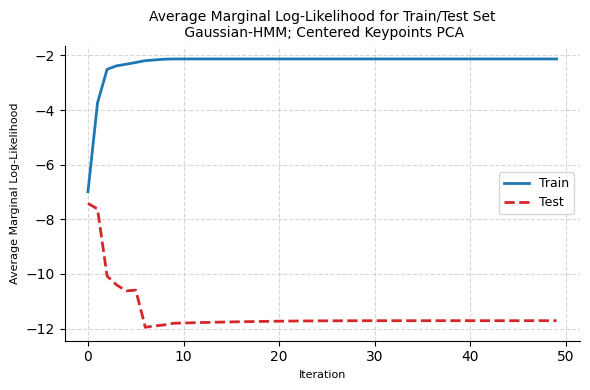

Final train LL: -2.1287
Final test LL: -11.7088


In [647]:
plot_log_likelihood_curves(train_lls, test_lls, title="Average Marginal Log-Likelihood for Train/Test Set\n Gaussian-HMM; Centered Keypoints PCA")

print(f'Final train LL: {train_lls[-1]:.4f}')
print(f'Final test LL: {test_lls[-1]:.4f}')

#### Train Plot

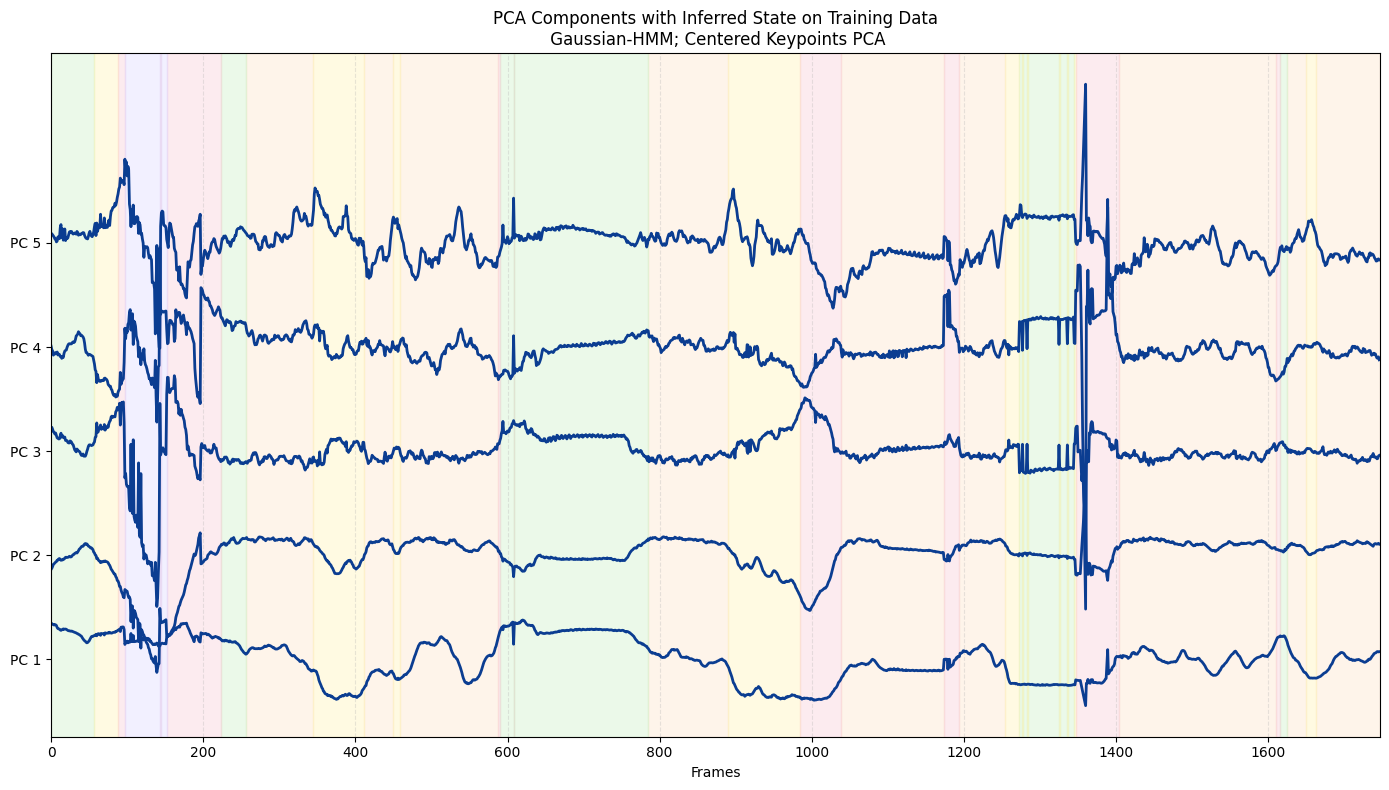

In [648]:
train_ghmm_states = train_posteriors[0]["expected_states"].argmax(1)
train_ghmm_usage = torch.bincount(train_ghmm_states, minlength=num_states)
train_ghmm_order = torch.argsort(train_ghmm_usage, descending=True)

train_pca_components = train_dataset[0][KEYPOINTS_TYPE]
plot_stacked_pca_with_ghmm_states(train_pca_components, train_ghmm_states, 'PCA Components with Inferred State on Training Data\n Gaussian-HMM; Centered Keypoints PCA')

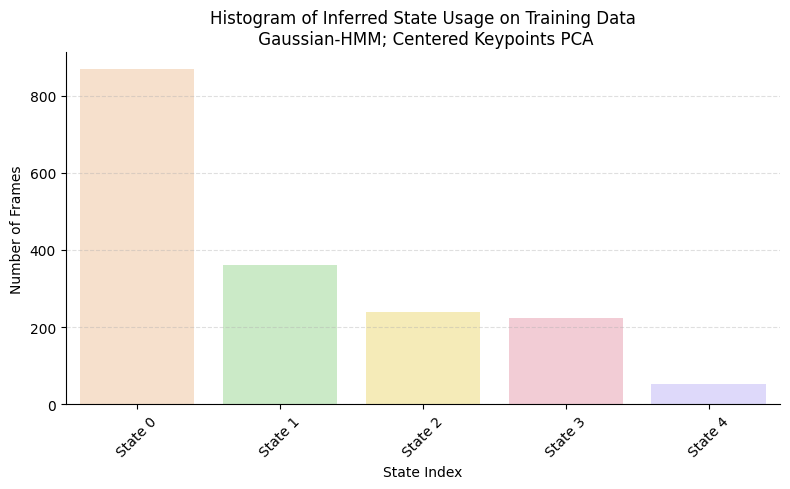

In [649]:
import warnings
warnings.filterwarnings('ignore')

train_ghmm_states = train_posteriors[0]["expected_states"].argmax(1)
train_ghmm_usage = torch.bincount(train_ghmm_states, minlength=num_states)
train_ghmm_order = torch.argsort(train_ghmm_usage, descending=True)

plot_state_usage(train_ghmm_states, num_states=num_states, title="Histogram of Inferred State Usage on Training Data\n Gaussian-HMM; Centered Keypoints PCA")

#### Test Plot

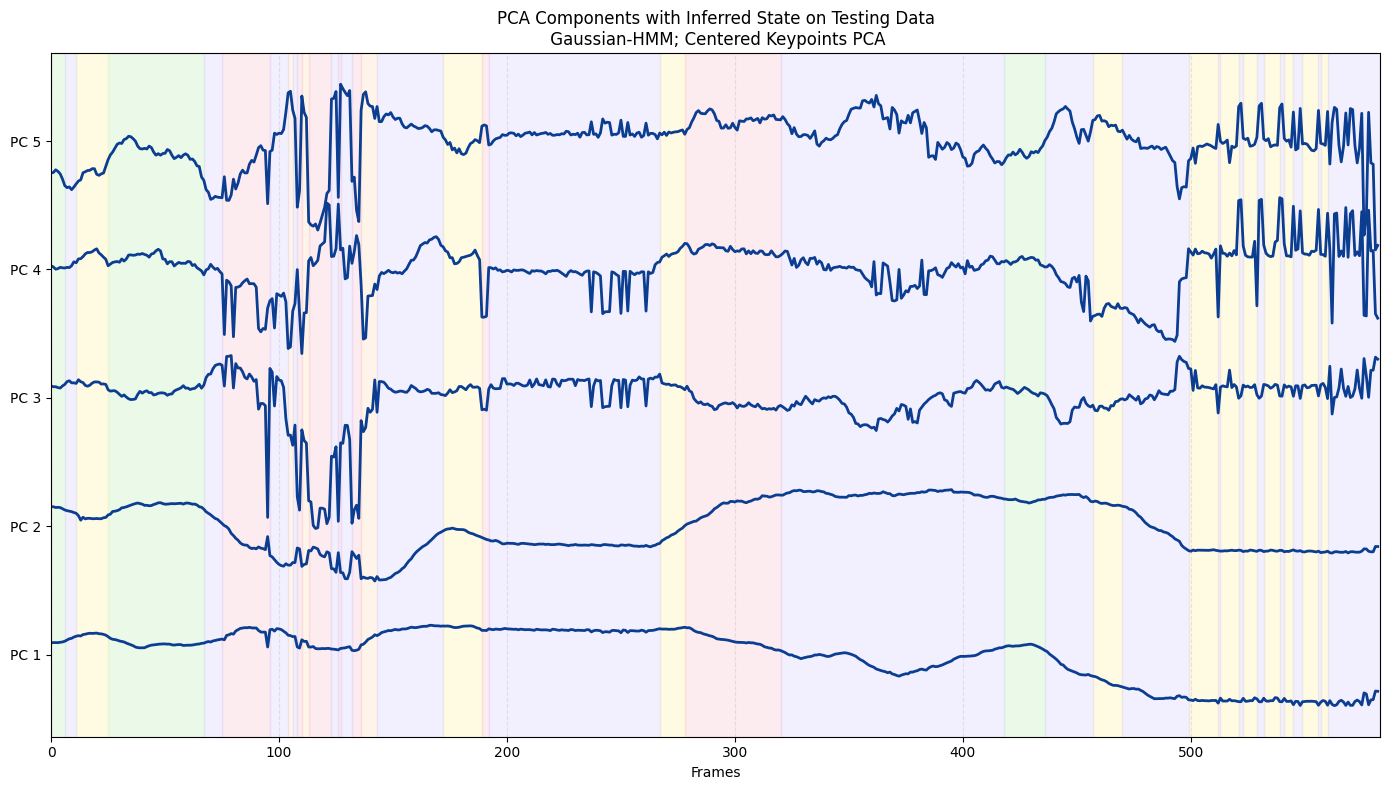

In [ ]:
test_ghmm_states = test_posteriors[0]["expected_states"].argmax(1)
test_ghmm_usage = torch.bincount(test_ghmm_states, minlength=num_states)
test_ghmm_order = torch.argsort(test_ghmm_usage, descending=True)
test_pca_components = test_dataset[0][KEYPOINTS_TYPE]
plot_stacked_pca_with_ghmm_states(test_pca_components, test_ghmm_states, 'PCA Components with Inferred State on Testing Data\n Gaussian-HMM; Centered Keypoints PCA')

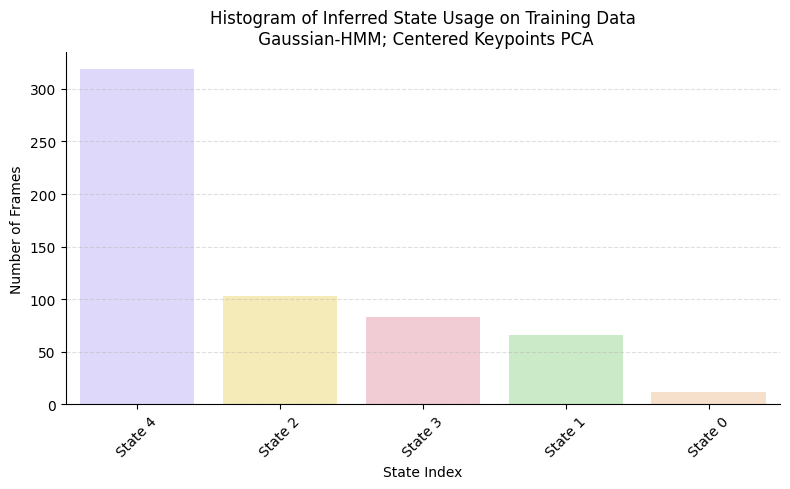

In [632]:
test_ghmm_states = test_posteriors[0]["expected_states"].argmax(1)
test_ghmm_usage = torch.bincount(test_ghmm_states, minlength=num_states)
test_ghmm_order = torch.argsort(test_ghmm_usage, descending=True)

warnings.filterwarnings('ignore')
plot_state_usage(test_ghmm_states, num_states=num_states, title="Histogram of Inferred State Usage on Training Data\n Gaussian-HMM; Centered Keypoints PCA")

# AR-HMM

In [653]:
#pca_centered_keypoints
#pca_gaussian_smoothed_keypoints
#pca_pose_constrained_keypoints
#pca_gaussian_smoothed_pose_constrained_keypoints

KEYPOINTS_TYPE = 'pca_pose_constrained_keypoints'
NUM_STATES = 4
TIME_LAGS = 3

In [654]:
class LinearRegressionObservations(object):
    """
    Wrapper for a collection of Gaussian observation parameters.
    """
    num_states: int      # K
    data_dim: int        # D (dimension of observed data y_t)
    covariate_dim: int   # M (dimension of covariates phi_t)

    weights: Float[torch.Tensor, "num_states data_dim covariate_dim"]       # W_k (K, D, M)
    covs: Float[torch.Tensor, "num_states data_dim data_dim"]               # Q_k (K, D, D)

    def __init__(self, num_states: int, data_dim: int, covariate_dim: int) -> None:
        """
        Initialize a collection of observation parameters for an HMM whose
        observation distributions are linear regressions. The HMM has
        `num_states` (i.e. K) discrete states, `data_dim` (i.e. D)
        dimensional observations, and `covariate_dim` covariates.
        In an ARHMM, the covariates will be functions of the past data.
        """
        self.num_states = num_states
        self.data_dim = data_dim
        self.covariate_dim = covariate_dim

        # Initialize the model parameters
        self.weights = torch.zeros((num_states, data_dim, covariate_dim))
        self.covs = torch.tile(torch.eye(data_dim), (num_states, 1, 1))

    @staticmethod
    def precompute_suff_stats(dataset: List[Dict[str, Any]]) -> None:
        """
        Compute the sufficient statistics of the linear regression for each
        data dictionary in the dataset. This modifies the dataset in place.

        Parameters
        ----------
        dataset: a list of data dictionaries.

        Returns
        -------
        Nothing, but the dataset is updated in place to have a new `suff_stats`
            key, which contains a tuple of sufficient statistics.
        """
        ###
        # YOUR CODE BELOW
        #
        for data in dataset:
            x = data[KEYPOINTS_TYPE]
            phi = data['covariates']

            data['suff_stats'] = (torch.ones(x.shape[0]),
                                  torch.einsum('tk,tj->tkj', x, x),
                                  torch.einsum('tk,tj->tkj', x, phi),
                                  torch.einsum('tk,tj->tkj', phi, phi))
        #
        ###

    def log_likelihoods(
            self,
            data: Dict[str, Any]
            ) -> Float[torch.Tensor, "num_timesteps num_states"]:
        """
        Compute the matrix of log likelihoods of data for each state.
        (I like to use torch.distributions for this, though it requires
         converting back and forth between numpy arrays and pytorch tensors.)

        Parameters
        ----------
        data: a dictionary with multiple keys, including "data", the TxD array
            of observations for this mouse.

        Returns
        -------
        log_likes: a TxK array of log likelihoods for each datapoint and
            discrete state.
        """
        ###
        # YOUR CODE BELOW
        #
        x = data[KEYPOINTS_TYPE]          # (T, D)
        phi = data["covariates"]  # (T, M)
        T = x.shape[0]
        K = self.num_states

        log_likes = torch.zeros((T, K))
        for k in range(K):
            Wk = self.weights[k]           # (D, M)
            Qk = self.covs[k]              # (D, D)

            jitter = 1e-4 * torch.eye(Qk.size(-1), device=Qk.device)
            Qk = Qk + jitter
            Qk = (Qk + Qk.T) / 2  # Ensure symmetry

            mu = phi @ Wk.T       # (T, D)
            x_centered = x - mu   # (T, D)

            try:
                L = torch.linalg.cholesky(Qk)  # L @ L.T = Qk
            except RuntimeError:
                # fallback: add more jitter or skip this k
                log_likes[:, k] = -1e10
                continue

            # Solve for Qk^{-1} (x - mu) via Cholesky
            solve = torch.cholesky_solve(x_centered.unsqueeze(-1), L)  # (T, D, 1)
            mahalanobis = (x_centered.unsqueeze(1) @ solve).squeeze()  # (T,)

            log_det = 2.0 * torch.sum(torch.log(torch.diagonal(L)))  # log|Qk|
            D = Qk.shape[0]

            log_prob = -0.5 * (D * torch.log(torch.tensor(2 * torch.pi)) + log_det + mahalanobis)
            log_likes[:, k] = log_prob


        #
        ###
        return log_likes

    def M_step(
        self,
        stats: Tuple[
            Float[torch.Tensor, "num_states"],
            Float[torch.Tensor, "num_states data_dim data_dim"],
            Float[torch.Tensor, "num_states data_dim covariate_dim"],
            Float[torch.Tensor, "num_states covariate_dim covariate_dim"]
        ]
    ) -> None:
        """
        Compute the linear regression parameters given the expected
        sufficient statistics.

        Note: add a little bit (1e-4 * I) to the diagonal of each covariance
            matrix to ensure that the result is positive definite.


        Parameters
        ----------
        stats: a tuple of expected sufficient statistics

        Returns
        -------
        Nothing, but self.weights and self.covs are updated in place.
        """
        Ns, t1s, t2s, t3s = stats
 
        ###
        # YOUR CODE BELOW
        eps = 1e-4 * torch.eye(self.data_dim)


        for k in range(self.num_states):
            if Ns[k] > 0:
                t3_inv = torch.linalg.pinv(t3s[k])    # Use pseudo-inverse for stability
                Wk = t2s[k] @ t3_inv
                Qk = t1s[k] - t2s[k] @ t3_inv.T @ t2s[k].T
                Qk = Qk / Ns[k] + eps
                Qk = (Qk + Qk.transpose(-1, -2)) / 2  # Force symmetry

                self.weights[k] = Wk
                self.covs[k] = Qk
        #
        ###

def precompute_ar_covariates(
    dataset: List[Dict[str, Any]],
    num_lags: int = 2,
    fit_intercept: bool = True
    ) -> None:
    """Precomputes autoregressive (AR) covariates for time series data.

    For each data item in `dataset` (which must contain a 'data' key mapping
    to a TxD_in tensor), this function generates AR features. These include
    `num_lags` lagged versions of the 'data' tensor (zero-padded at the start)
    and optionally an intercept term. The resulting covariate matrix is added
    to each data item's dictionary under the key 'covariates' (in-place).

    Args:
        dataset: A list of dictionaries. Each dictionary is expected to have
                 a 'data' key with a 2D PyTorch Tensor (time_steps x features).
                 These dictionaries are modified in-place.
        num_lags: Number of past time steps to include as covariates.
                  Defaults to 2.
        fit_intercept: If True, adds a constant intercept term (a column of
                       ones) to the covariates. Defaults to True.

    Returns:
        None. The `dataset` dictionaries are modified directly.
    """
    for data in dataset:
        x = data[KEYPOINTS_TYPE]
        data_dim = x.shape[1]

        T, D = x.shape

        # Pad the beginning with zeros
        padded = torch.cat([
            torch.zeros((num_lags, D), device=x.device),
            x
        ], dim=0)

        # MOST RECENT lag first: x_{t-1}, x_{t-2}, ..., x_{t-G}
        lagged = [
            padded[lag - 1 : T + lag - 1]
            for lag in range(num_lags, 0, -1)
        ]

        phi = torch.cat(lagged, dim=1)      # shape: (T, D * num_lags)

        # Add intercept term if needed
        if fit_intercept:
            intercept = torch.ones((T, 1), device=x.device)
            phi = torch.cat([phi, intercept], dim=1)

        data["covariates"] = phi  # shape (T, D*num_lags [+1 if intercept])
        #
        ###

In [655]:
num_lags = TIME_LAGS
precompute_ar_covariates(train_dataset, num_lags=num_lags)
precompute_ar_covariates(test_dataset, num_lags=num_lags)
LinearRegressionObservations.precompute_suff_stats(train_dataset)
LinearRegressionObservations.precompute_suff_stats(test_dataset)

In [656]:
# Build the HMM
num_states = NUM_STATES
data_dim = train_dataset[0][KEYPOINTS_TYPE].shape[1]
initial_dist = torch.ones(num_states) / num_states
transition_matrix = sticky_transitions(num_states, stickiness=0.95)
observations = LinearRegressionObservations(num_states, data_dim,
                                            num_lags * data_dim + 1)


# Fit it!
train_lls, test_lls, train_posteriors, test_posteriors, = \
    fit_hmm(train_dataset[:1],
            test_dataset[:1],
            initial_dist,
            transition_matrix,
            observations,
            num_iters=60)


  0%|          | 0/60 [00:00<?, ?it/s]

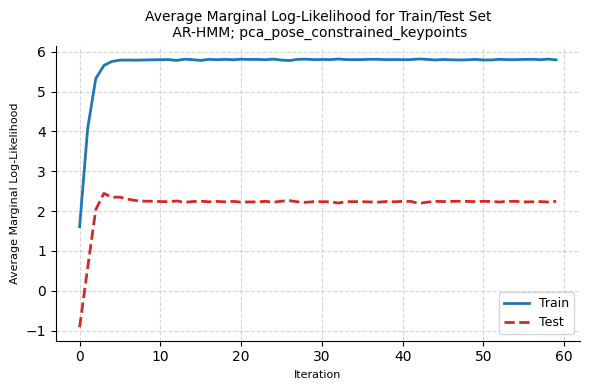

Final train LL: 5.7938
Final test LL: 2.2437


In [657]:
plot_log_likelihood_curves(train_lls, test_lls, title=f"Average Marginal Log-Likelihood for Train/Test Set\n AR-HMM; {KEYPOINTS_TYPE}")

print(f'Final train LL: {train_lls[-1]:.4f}')
print(f'Final test LL: {test_lls[-1]:.4f}')

#### Train Plot

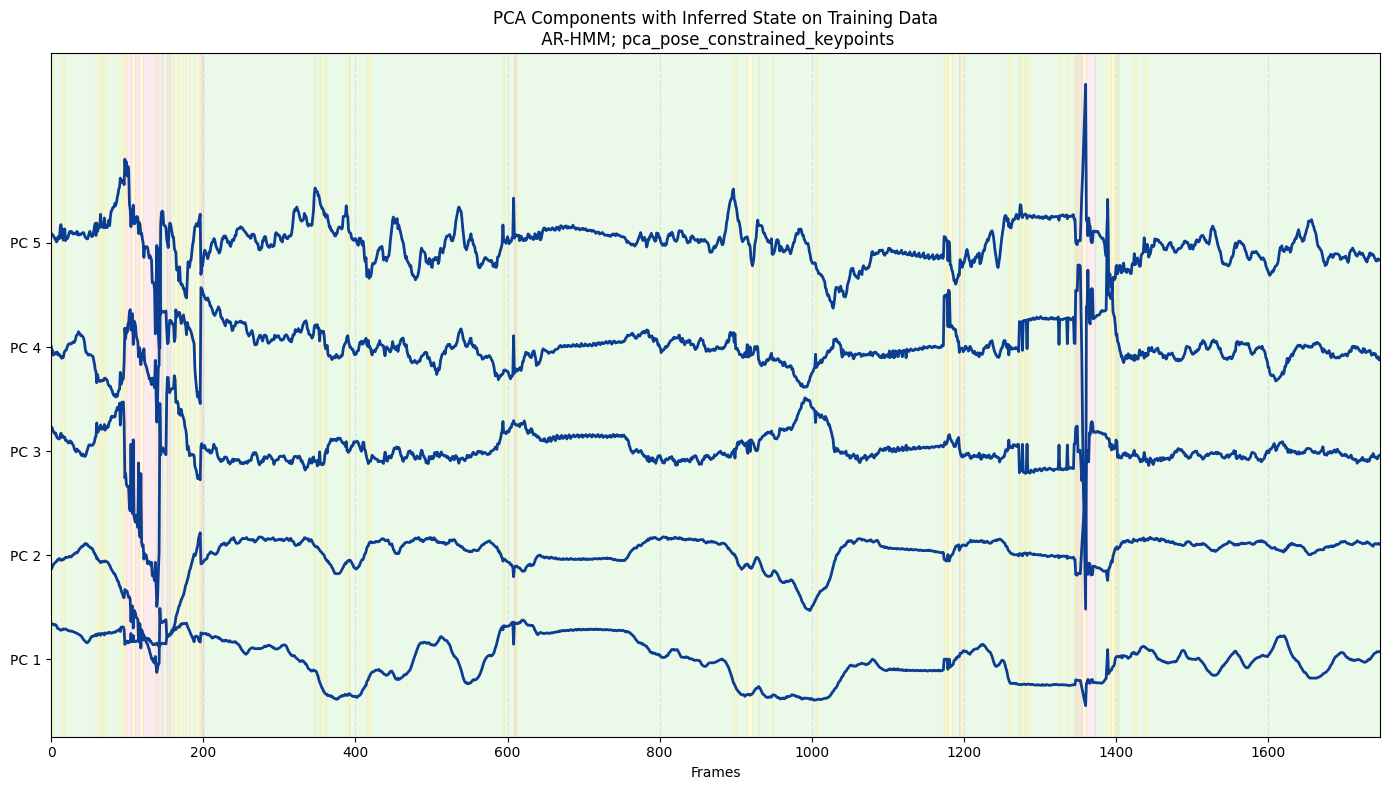

In [658]:
train_ghmm_states = train_posteriors[0]["expected_states"].argmax(1)
train_ghmm_usage = torch.bincount(train_ghmm_states, minlength=num_states)
train_ghmm_order = torch.argsort(train_ghmm_usage, descending=True)

train_pca_components = train_dataset[0][KEYPOINTS_TYPE]
plot_stacked_pca_with_ghmm_states(train_pca_components, train_ghmm_states, f'PCA Components with Inferred State on Training Data\n AR-HMM; {KEYPOINTS_TYPE}')

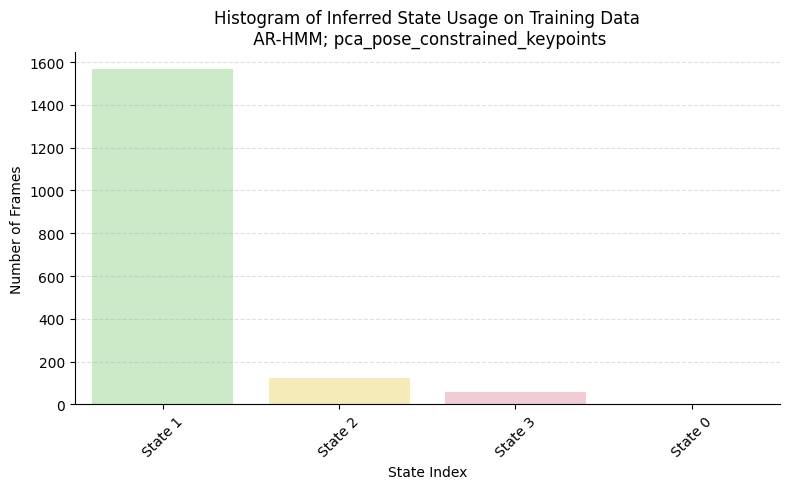

In [659]:
import warnings
warnings.filterwarnings('ignore')

train_ghmm_states = train_posteriors[0]["expected_states"].argmax(1)
train_ghmm_usage = torch.bincount(train_ghmm_states, minlength=num_states)
train_ghmm_order = torch.argsort(train_ghmm_usage, descending=True)

plot_state_usage(
    train_ghmm_states, 
    num_states=num_states, 
    title=f"Histogram of Inferred State Usage on Training Data\n AR-HMM; {KEYPOINTS_TYPE}"
)

#### Test Plot

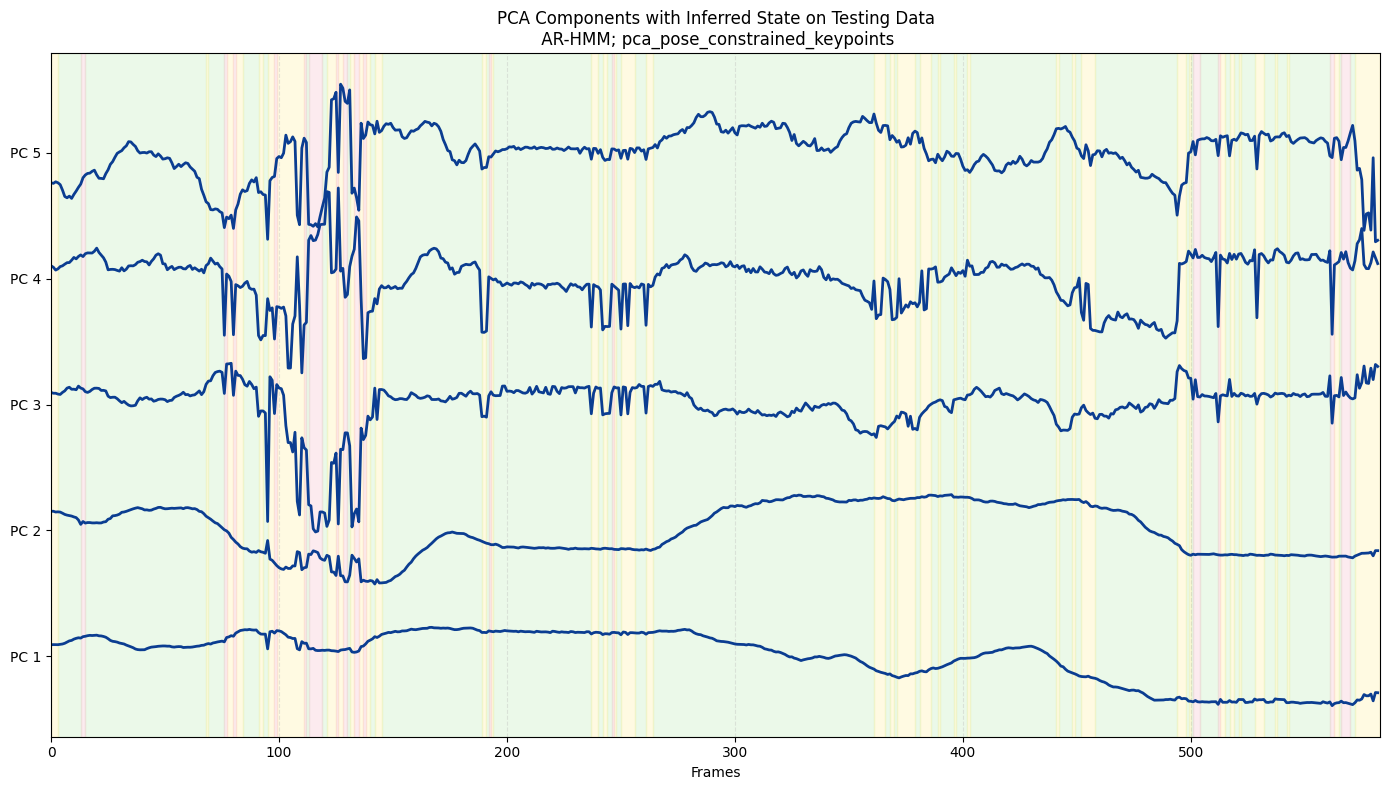

In [660]:
test_ghmm_states = test_posteriors[0]["expected_states"].argmax(1)
test_ghmm_usage = torch.bincount(test_ghmm_states, minlength=num_states)
test_ghmm_order = torch.argsort(test_ghmm_usage, descending=True)
test_pca_components = test_dataset[0][KEYPOINTS_TYPE]
plot_stacked_pca_with_ghmm_states(
    test_pca_components, 
    test_ghmm_states, 
    f'PCA Components with Inferred State on Testing Data\n AR-HMM; {KEYPOINTS_TYPE}'
)

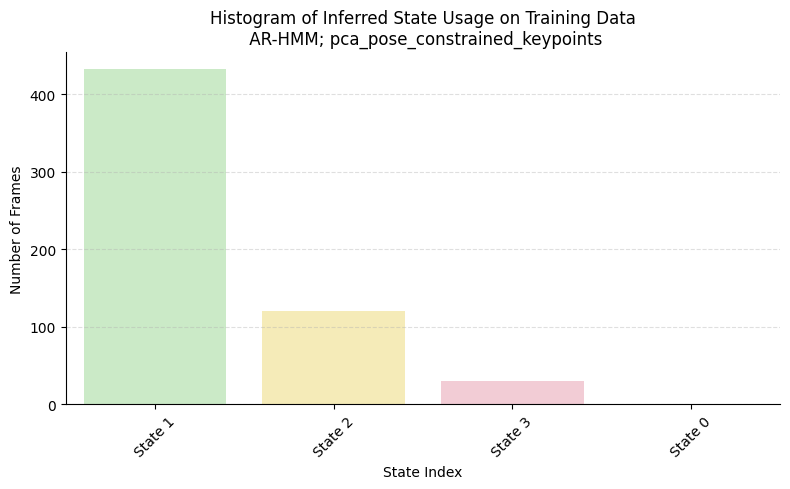

In [661]:
test_ghmm_states = test_posteriors[0]["expected_states"].argmax(1)
test_ghmm_usage = torch.bincount(test_ghmm_states, minlength=num_states)
test_ghmm_order = torch.argsort(test_ghmm_usage, descending=True)

warnings.filterwarnings('ignore')
plot_state_usage(
    test_ghmm_states, 
    num_states=num_states, 
    title=f"Histogram of Inferred State Usage on Training Data\n AR-HMM; {KEYPOINTS_TYPE}")

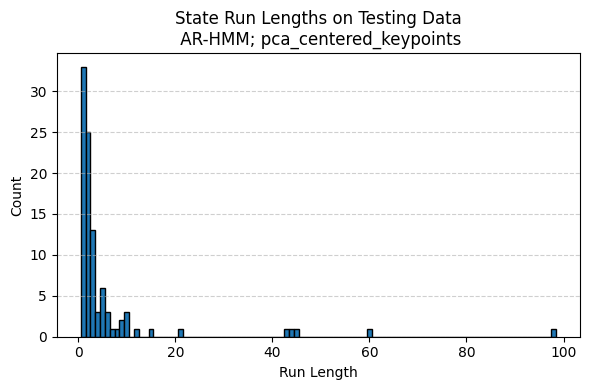

In [594]:
plot_state_run_lengths(test_ghmm_states, title = f"State Run Lengths on Testing Data\n AR-HMM; {KEYPOINTS_TYPE}")

# Autocorrelation Plot

In [312]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

def plot_autocorrelation(tensor, max_lag=100):
    """
    Plots autocorrelation for each dimension of a T x D tensor
    in a 2x3 grid. For 5 components, the last row is centered.
    
    Args:
        tensor: numpy array of shape (T, D)
        max_lag: maximum lag to compute autocorrelation
    """
    T, D = tensor.shape
    assert D == 5, "This layout is designed for exactly 5 PCA components."

    fig, axes = plt.subplots(2, 3, figsize=(12, 6))
    axes = axes.flatten()

    # Plot first 3 components in first row
    for d in range(3):
        signal = tensor[:, d]
        acorr = acf(signal, nlags=max_lag, fft=True)
        axes[d].stem(range(max_lag + 1), acorr)
        axes[d].set_title(f'ACF of PC {d+1}')
        axes[d].set_ylabel("ACF")
        axes[d].set_xlabel("Lag")

    # Leave 0 and 2 blank in second row, plot 4th and 5th components in center positions
    for i in [0, 2]:
        fig.delaxes(axes[3 + i])  # delete left and right subplot in second row

    for d in range(3, 5):
        idx = 3 + (d - 3) + 1  # shift to center columns: 4th in col=1, 5th in col=2
        signal = tensor[:, d]
        acorr = acf(signal, nlags=max_lag, fft=True)
        axes[idx].stem(range(max_lag + 1), acorr)
        axes[idx].set_title(f'ACF of PC {d+1}')
        axes[idx].set_ylabel("ACF")
        axes[idx].set_xlabel("Lag")

    plt.tight_layout()
    plt.show()


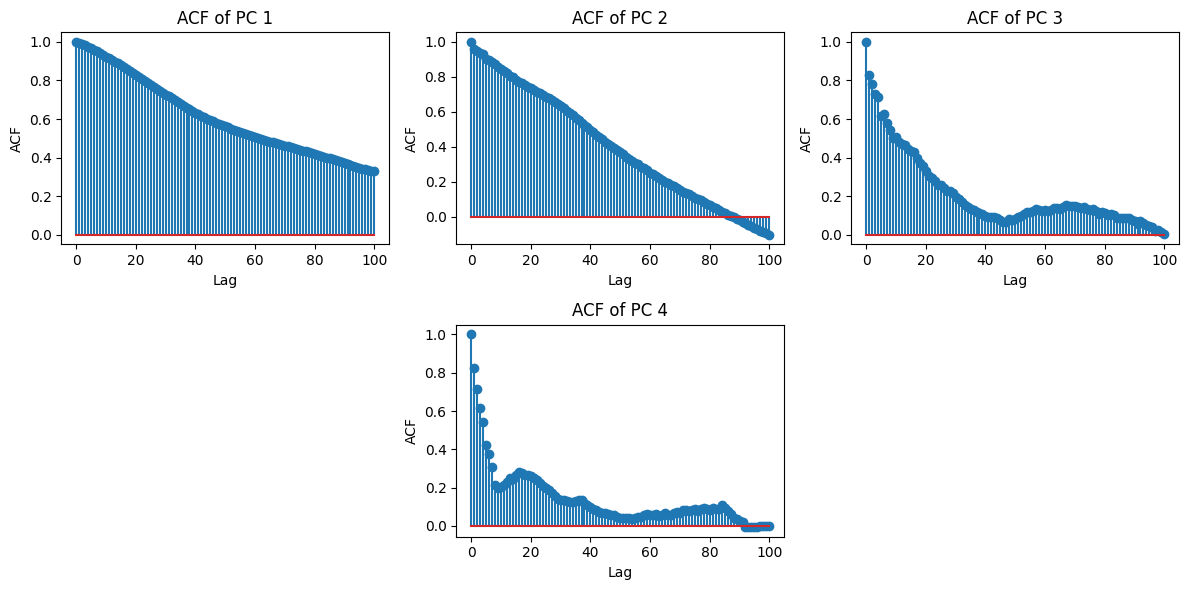

In [313]:
plot_autocorrelation(train_dataset[0]['pca_centered_keypoints'])